# Energy and Buildings Paper V4

In [64]:
import pandas as pd
import requests
import pvlib
import matplotlib.pyplot as plt  # for visualization
import math
from datetime import datetime
from ast import literal_eval
from statistics import median
from statistics import mean

In [65]:
#variables - MAKE SURE THESE ARE IDENTICAL TO WHAT WAS USED IN THE MODEL
myNetworks = ['bowling green','long island city','sunnyside','crown heights','grasslands','fresh kills','williamsburg','northeast bronx','ridgewood']

#these are the columns with lists in them
strToList = ['dailyPVWAC_4M','annualPVkWhDC_degraded','annualPVkWhAC_degraded','avoidedGridCosts','avgAutoParticipationMonthlyW_C','avgAutoParticipationMonthlyW_D','avgAutoParticipationAnnualW_C','avgAutoParticipationAnnualW_D','drIncMonthly_C','drIncMonthly_D','drIncAnnual_C','drIncAnnual_D','drPerformanceIncome','annualBenefit']

# Read Data

## Read Model Results

In [66]:
results_df = pd.read_csv('results/results_df_1710792232.csv')

#drop the index if it was saved in the  file
results_df = results_df.drop(columns='Unnamed: 0')
results_df.head()

,network,eventStart,az,pvW,batModel,batWh,batWhAC,effEff,dischargeRateW,capex,...,drIncAnnual_D,drPerformanceIncome,annualBenefit,realRoi,Cycles,lifespan,workingLife,profitableYears,incomeAfterRoi,iarSplit
0,bowling green,11,110,40,Explorer 300 Plus,288.0,240.558917,0.835274,57.6,512.659713,...,"[3.940796469102418, 3.940796469102418, 3.94079...","[0.6888734193870574, 0.687021531378572, 0.6851...","[10.862171948682787, 10.77312001650309, 10.680...",51.370537,3000,8.219178,8.219178,0.0,0.0,0.0
1,bowling green,11,110,40,Explorer 300 Plus,288.0,240.558917,0.835274,57.6,512.659713,...,"[2.3622713900922294, 3.940796469102418, 3.9407...","[0.6888734193870574, 0.687021531378572, 0.6851...","[9.283646869672598, 10.77312001650309, 10.6808...",51.529411,3000,8.219178,8.219178,0.0,0.0,0.0
2,bowling green,11,110,40,Explorer 300 Plus,288.0,240.558917,0.835274,57.6,512.659713,...,"[2.3622713900922294, 2.333132360629758, 2.3042...","[0.6888734193870574, 0.687021531378572, 0.6851...","[9.283646869672598, 9.165455908030431, 9.04434...",52.193943,3000,8.219178,8.219178,0.0,0.0,0.0
3,bowling green,11,110,50,Explorer 300 Plus,288.0,240.558917,0.835274,57.6,524.635963,...,"[3.940796469102418, 3.940796469102418, 3.94079...","[0.7351635705803974, 0.7328494296700228, 0.730...","[13.70076295102532, 13.644573660799256, 13.585...",40.024681,3000,8.219178,8.219178,0.0,0.0,0.0
4,bowling green,11,110,50,Explorer 300 Plus,288.0,240.558917,0.835274,57.6,524.635963,...,"[3.090416769067076, 3.940796469102418, 3.94079...","[0.7351635705803974, 0.7328494296700228, 0.730...","[12.850383250989978, 13.644573660799256, 13.58...",40.089635,3000,8.219178,8.219178,0.0,0.0,0.0


In [67]:
#convert strings to lists
for c in strToList:
    results_df[c] = results_df[c].apply(literal_eval)

In [68]:
#check data types if needed
# for k in list(results_df.keys()):
#     print(k)
#     print(type(results_df.iloc[0][k]))
#     if type(results_df.iloc[0][k]).__name__ == 'list':
#         print(type(results_df.iloc[0][k][0]))
#     print(results_df.iloc[0][k])

## Read in network data

In [69]:
# read in hardware data to dataframe
networks_df = pd.read_csv('data/conEdNetworks2024.csv')

display(networks_df.head())

,borough,network,start time,end time,tier
0,bronx,central bronx,16:00,20:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,2
4,bronx,southeast bronx,16:00,20:00,2


In [70]:
#returns the network info for a given network
#args: network name
def getNetworkInfo(networkName):
    return networks_df.loc[networks_df['network']== networkName]

#returns the tier for a given item in the network info list
#args: network name
def getDLRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['tier'].iloc[0]
    #tier 2 networks pay at a higher rate
    if t == 1:
        return 18
    else:
        return 25
    
#returns the borough for a given item in the network info list
#args: network name
def getCSRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['borough'].iloc[0]
    #westchester and staten island pay at a lower rate
    if t not in ['westchester','staten island']:
        return 18
    else:
        return 6

#args: network name
def getTotalRate(networkName):
    return getDLRPrate(networkName) + getCSRPrate(networkName)
    
#returns borough name
#args: network name
def getBorough(networkName):
    n = getNetworkInfo(networkName)
    return n['borough'].iloc[0]

#returns event start time
#args: network name
def getStartTime(networkName):
    n = getNetworkInfo(networkName)
    return int(n['start time'].iloc[0].split(":")[0])

# Analyze Results

In [71]:
#total results
results_df.shape[0]

158679

In [72]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batModel', 'batWh', 'batWhAC',
       'effEff', 'dischargeRateW', 'capex', 'dollarPerBatkWh', 'dailyPVWAC_4M',
       'annualPVkWhDC_degraded', 'annualPVkWhAC_degraded', 'avoidedGridCosts',
       'immediateEventAmt', 'avgAutoParticipationMonthlyW_C',
       'avgAutoParticipationMonthlyW_D', 'avgAutoParticipationAnnualW_C',
       'avgAutoParticipationAnnualW_D', 'avgMAPw_C', 'avgMAPw_D',
       'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D', 'drIncAnnual_C',
       'drIncAnnual_D', 'drPerformanceIncome', 'annualBenefit', 'realRoi',
       'Cycles', 'lifespan', 'workingLife', 'profitableYears',
       'incomeAfterRoi', 'iarSplit'],
      dtype='object')

In [73]:
#results_df['annualPVkWhAC_degraded'].iloc[200]

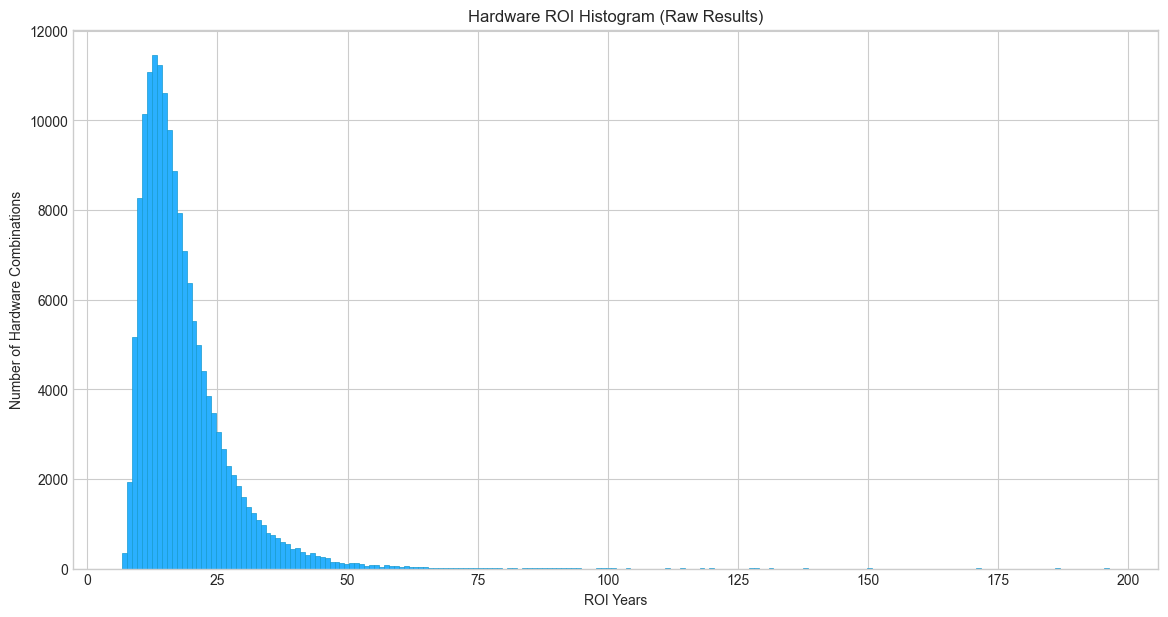

In [74]:
# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(results_df['realRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware ROI Histogram (Raw Results)') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

## Filtering to Favorable ROIs

In [75]:
#filter out anything with an ROI over its working years
favROI_df = results_df[results_df['realRoi'] <= results_df['workingLife']] 

favROI_df_Z = favROI_df[favROI_df['immediateEventAmt'] == 0] 
favROI_df_O = favROI_df[favROI_df['immediateEventAmt'] == 1] 
favROI_df_F = favROI_df[favROI_df['immediateEventAmt'] == 5] 

In [76]:
#get list of battery sizes
favBatWh = list(favROI_df['batWh'].unique())

In [77]:
#get total combinations by azimuth, frequency, and network

print('Total Combinations')
print(str(favROI_df.shape[0])+ ' total favorable ROI hardware combinations generated')
print(str(favROI_df_Z.shape[0])+ ' total favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O.shape[0])+ ' total favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F.shape[0])+ ' total favorable ROI hardware combinations generated - Five Immediate Event')
print('')

print('Eastern')
print(str(favROI_df[favROI_df['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==110].shape[0])+ ' eastern favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==110].shape[0]/favROI_df_F[favROI_df_F['az']==110].shape[0])) #the closer to 1, the less impactful
print('')

print('Southern')
print(str(favROI_df[favROI_df['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==180].shape[0])+ ' southern favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==180].shape[0]/favROI_df_F[favROI_df_F['az']==180].shape[0])) #the closer to 1, the less impactful
print('')

print('Western')
print(str(favROI_df[favROI_df['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated')
print(str(favROI_df_Z[favROI_df_Z['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - Zero Immediate Event')
print(str(favROI_df_O[favROI_df_O['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - One Immediate Event')
print(str(favROI_df_F[favROI_df_F['az']==250].shape[0])+ ' western favorable ROI hardware combinations generated - Five Immediate Event')
print('Impact: ' + str(favROI_df_Z[favROI_df_Z['az']==250].shape[0]/favROI_df_F[favROI_df_F['az']==250].shape[0])) #the closer to 1, the less impactful


Total Combinations
7404 total favorable ROI hardware combinations generated
2538 total favorable ROI hardware combinations generated - Zero Immediate Event
2507 total favorable ROI hardware combinations generated - One Immediate Event
2359 total favorable ROI hardware combinations generated - Five Immediate Event

Eastern
1958 eastern favorable ROI hardware combinations generated
663 eastern favorable ROI hardware combinations generated - Zero Immediate Event
657 eastern favorable ROI hardware combinations generated - One Immediate Event
638 eastern favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0391849529780564

Southern
3466 southern favorable ROI hardware combinations generated
1184 southern favorable ROI hardware combinations generated - Zero Immediate Event
1174 southern favorable ROI hardware combinations generated - One Immediate Event
1108 southern favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.068592057761733

Wes

In [78]:
for n in myNetworks:
    print('Network: ' + n)
    tempDF = favROI_df[favROI_df['network']==n]

    tempDF_Z = tempDF[tempDF['immediateEventAmt'] == 0]
    tempDF_O = tempDF[tempDF['immediateEventAmt'] == 1]
    tempDF_F = tempDF[tempDF['immediateEventAmt'] == 5]

    print('Total Combinations')
    print(str(tempDF.shape[0])+ ' total favorable ROI hardware combinations generated')
    print(str(tempDF_Z.shape[0])+ ' total favorable ROI hardware combinations generated - Zero Immediate Event')
    print(str(tempDF_O.shape[0])+ ' total favorable ROI hardware combinations generated - One Immediate Event')
    print(str(tempDF_F.shape[0])+ ' total favorable ROI hardware combinations generated - Five Immediate Event')
    print('Impact: ' + str(tempDF_Z.shape[0]/tempDF_F.shape[0])) #the closer to 1, the less impactful
    
    print('')

Network: bowling green
Total Combinations
1312 total favorable ROI hardware combinations generated
445 total favorable ROI hardware combinations generated - Zero Immediate Event
443 total favorable ROI hardware combinations generated - One Immediate Event
424 total favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0495283018867925

Network: long island city
Total Combinations
930 total favorable ROI hardware combinations generated
317 total favorable ROI hardware combinations generated - Zero Immediate Event
313 total favorable ROI hardware combinations generated - One Immediate Event
300 total favorable ROI hardware combinations generated - Five Immediate Event
Impact: 1.0566666666666666

Network: sunnyside
Total Combinations
667 total favorable ROI hardware combinations generated
227 total favorable ROI hardware combinations generated - Zero Immediate Event
226 total favorable ROI hardware combinations generated - One Immediate Event
214 total favorable R

In [79]:
#network combos by azimuth
print("Network combos by azimuth - Zero Immediate Event")
for n in myNetworks:
    print('Network: ' + n)
    tempDF = favROI_df[favROI_df['network']==n]
    tempDF_Z = tempDF[tempDF['immediateEventAmt'] == 0]

    for a in [110,180,250]:
        print('Azimuth ' + str(a) + ": " + str(tempDF_Z[tempDF_Z['az']==a].shape[0])+ ' total favorable ROI hardware combinations generated')
    print('')

Network combos by azimuth - Zero Immediate Event
Network: bowling green
Azimuth 110: 122 total favorable ROI hardware combinations generated
Azimuth 180: 200 total favorable ROI hardware combinations generated
Azimuth 250: 123 total favorable ROI hardware combinations generated

Network: long island city
Azimuth 110: 76 total favorable ROI hardware combinations generated
Azimuth 180: 144 total favorable ROI hardware combinations generated
Azimuth 250: 97 total favorable ROI hardware combinations generated

Network: sunnyside
Azimuth 110: 56 total favorable ROI hardware combinations generated
Azimuth 180: 111 total favorable ROI hardware combinations generated
Azimuth 250: 60 total favorable ROI hardware combinations generated

Network: crown heights
Azimuth 110: 51 total favorable ROI hardware combinations generated
Azimuth 180: 100 total favorable ROI hardware combinations generated
Azimuth 250: 40 total favorable ROI hardware combinations generated

Network: grasslands
Azimuth 110: 2

In [80]:
#median performance

print('Median DR Performance - Watts')
print('')

print(str(favROI_df['avgMAPw_C'].median())+ ' Median CSRP - Total')
print(str(favROI_df['avgMAPw_D'].median())+ ' Median DRLP - Total')
print(str(favROI_df_Z['avgMAPw_C'].median())+ ' Median CSRP - Zero')
print(str(favROI_df_Z['avgMAPw_D'].median())+ ' Median DRLP - Zero')
print(str(favROI_df_O['avgMAPw_C'].median())+ ' Median CSRP - One')
print(str(favROI_df_O['avgMAPw_D'].median())+ ' Median DRLP - One')
print(str(favROI_df_F['avgMAPw_C'].median())+ ' Median CSRP - Five')
print(str(favROI_df_F['avgMAPw_D'].median())+ ' Median DRLP - Five')

for a in [110,180,250]:
    print('')
    print(str(a) + ' degrees')
    print('DRLP')
    #print(str(favROI_df[favROI_df['az']==a]['avgMAPw_D'].median())+ ' eastern favorable ROI hardware combinations generated')
    print(str(favROI_df_Z[favROI_df_Z['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - Zero Immediate Event')
    print(str(favROI_df_O[favROI_df_O['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - One Immediate Event')
    print(str(favROI_df_F[favROI_df_F['az']==a]['avgMAPw_D'].median())+ ' DLRP Median Performance - Five Immediate Event')
    print('CSRP')
    #print(str(favROI_df[favROI_df['az']==a]['avgMAPw_C'].median())+ ' eastern favorable ROI hardware combinations generated')
    print(str(favROI_df_Z[favROI_df_Z['az']==a]['avgMAPw_C'].median())+ ' CRSP Median Performance - Zero Immediate Event')
    print(str(favROI_df_O[favROI_df_O['az']==a]['avgMAPw_C'].median())+ ' CRSP - One Immediate Event')
    print(str(favROI_df_F[favROI_df_F['az']==a]['avgMAPw_C'].median())+ ' CRSP - Five Immediate Event')

Median DR Performance - Watts

295.5885502312744 Median CSRP - Total
244.80502561365523 Median DRLP - Total
300.0077900131793 Median CSRP - Zero
248.7875657316121 Median DRLP - Zero
297.939351743046 Median CSRP - One
248.7875657316121 Median DRLP - One
289.34756206031545 Median CSRP - Five
205.63087533464773 Median DRLP - Five

110 degrees
DRLP
248.7875657316121 DLRP Median Performance - Zero Immediate Event
248.7875657316121 DLRP Median Performance - One Immediate Event
205.63087533464773 DLRP Median Performance - Five Immediate Event
CSRP
278.51420626981 CRSP Median Performance - Zero Immediate Event
278.16892055125174 CRSP - One Immediate Event
275.1120528906399 CRSP - Five Immediate Event

180 degrees
DRLP
248.7875657316121 DLRP Median Performance - Zero Immediate Event
248.7875657316121 DLRP Median Performance - One Immediate Event
217.2747046256439 DLRP Median Performance - Five Immediate Event
CSRP
295.5885502312744 CRSP Median Performance - Zero Immediate Event
294.959376436413

In [200]:
favROI_df_Z[favROI_df_Z['realRoi']<8.3].shape[0]/favROI_df_Z.shape[0]

0.15011820330969267

In [183]:
#ROI data

#arg: results DF
def snapShot(rDF):
    print('Amount of systems: ' +str(rDF.shape[0]))
    print('')
    
    #lifespan
    print("Min Lifespan: " + str(min(rDF['lifespan'])))
    print("Mean Lifespan: " + str(rDF['lifespan'].mean()))
    print("Median Lifespan: " + str(rDF['lifespan'].median()))
    print("Max Lifespan: " + str(max(rDF['lifespan'])))
    print('')

    #working life
    print("Min working life: " + str(min(rDF['workingLife'])))
    print("Mean working life: " + str(rDF['workingLife'].mean()))
    print("Median working life: " + str(rDF['workingLife'].median()))
    print("Max working life: " + str(max(rDF['workingLife'])))
    print('')
    
    # fastest ROI
    fARoi = rDF[rDF['realRoi'] == min(rDF['realRoi'])]
    print("Fastest ROI: " + str(fARoi['realRoi'].iloc[0]) + "yrs")

    mARoi = rDF['realRoi'].mean()
    print("Mean ROI: " + str(mARoi))
    
    print("Median ROI: " + str(rDF['realRoi'].median()))
    # slowest ROI
    sARoi = rDF[rDF['realRoi'] == max(rDF['realRoi'])]
    print("Slowest ROI: " + str(sARoi['realRoi'].iloc[0]) + "yrs")

    print('')

    # Income After ROI
    maxAIAR = rDF[rDF['incomeAfterRoi'] == max(rDF['incomeAfterRoi'])]
    print("Greatest IAR: $" + str(maxAIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(maxAIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,maxAIAR['lifespan'].iloc[0])) +' years)')

    mAIRoi = rDF['incomeAfterRoi'].mean()
    print("Mean IAR: " + str(mAIRoi))

    print("Median IAR: " + str(rDF['incomeAfterRoi'].median()))
    
    minAIAR = rDF[rDF['incomeAfterRoi'] == min(rDF['incomeAfterRoi'])]
    print("Lowest IAR: $" + str(minAIAR['incomeAfterRoi'].iloc[0]) + " ($" + str(minAIAR['iarSplit'].iloc[0]) + '/per year for '+ str(min(10,minAIAR['lifespan'].iloc[0])) +' years)')

    print('')
    
    # Income After ROI Split
    print("Greatest IAR Split: $" + str(max(rDF['iarSplit'])))

    print("Mean IAR Split: " + str(rDF['iarSplit'].mean()))
    print("Median IAR Split: " + str(rDF['iarSplit'].median()))

    print("Lowest IAR Split: $" + str(min(rDF['iarSplit'])))

    print('')
    
    #min PV
    md = rDF[rDF['pvW'] == min(rDF['pvW'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Minimum PV Arrays: ")
    print(set(a))
    
    #max PV
    md = rDF[rDF['pvW'] == max(rDF['pvW'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Maximum PV Arrays: ")
    print(set(a))  
    
    print("mean PV: " + str(rDF['pvW'].mean()))
    print("median PV: " + str(rDF['pvW'].median()))

    print('')

    #min BAT
    md = rDF[rDF['batWh'] == min(rDF['batWh'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Minimum Bat Wh: ")
    print(set(a))
    
    #max BAT
    md = rDF[rDF['batWh'] == max(rDF['batWh'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWh']]
        a.append(str(m))
    print("Combinations with Maximum Bat Wh: ")
    print(set(a))  

    print("mean Bat Wh: " + str(rDF['batWh'].mean()))
    print("median Bat Wh: " + str(rDF['batWh'].median()))
    print('')

    #min BATAC
    md = rDF[rDF['batWhAC'] == min(rDF['batWhAC'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWhAC']]
        a.append(str(m))
    print("Combinations with Minimum Bat Wh AC: ")
    print(set(a))
    

    #max BATAC
    md = rDF[rDF['batWhAC'] == max(rDF['batWhAC'])]
    a = []
    for i, r in md.iterrows():
        m = [r['pvW'],r['batWhAC']]
        a.append(str(m))
    print("Combinations with Maximum Bat Wh AC: ")
    print(set(a))  

    print("mean Bat Wh AC: " + str(rDF['batWhAC'].mean()))
    print("median Bat Wh AC: " + str(rDF['batWhAC'].median()))

    print('')

    #CSRP performance
    print("Min CSRP W Performance: " + str(round(min(rDF['avgMAPw_C']),2)))
    print("Mean CSRP W Performance: " + str(round(rDF['avgMAPw_C'].mean(),2)))
    print("Median CSRP W Performance: " + str(round(rDF['avgMAPw_C'].median(),2)))
    print("Max CSRP W Performance: " + str(round(max(rDF['avgMAPw_C']),2)))

    print('')

    #DLRP performance
    print("Min DLRP W Performance: " + str(round(min(rDF['avgMAPw_D']),2)))
    print("Mean DLRP W Performance: " + str(round(rDF['avgMAPw_D'].mean(),2)))
    print("Median DLRP W Performance: " + str(round(rDF['avgMAPw_D'].median(),2)))
    print("Max DLRP W Performance: " + str(round(max(rDF['avgMAPw_D']),2)))
    
    print('')
    
    #DR inc
    #theres a better  way to do this with Lambda
    # ['drIncAnnual_D'].apply(lambda x: mean(x))),
    incL = []
    for i, r in rDF[['drIncAnnual_C','drIncAnnual_D','drPerformanceIncome']].iterrows():
        l = len(r['drIncAnnual_C'])
        incL.append(sum(r['drIncAnnual_C'])/l + sum(r['drIncAnnual_D'])/l + sum(r['drPerformanceIncome'])/l)
    
    rDF['totalDR_AnnualAvgInc'] = incL
    #display(rDF['totalDR_AnnualAvgInc'].head())
    print('Min Avg Annual DR Income: ' + str(round(min(rDF['totalDR_AnnualAvgInc']),2)))
    print('Mean Avg Annual DR Income: ' + str(round(rDF['totalDR_AnnualAvgInc'].mean(),2)))
    print('Median Avg Annual DR Income: ' + str(round(rDF['totalDR_AnnualAvgInc'].median(),2)))
    print('Max Avg Annual DR Income: ' + str(round(max(rDF['totalDR_AnnualAvgInc']),2)))
    
    print('')
    avgAnnBene = rDF['annualBenefit'].apply(lambda x: mean(x)).mean()
    print('Min Avg Annual Econ Benefits: ' + str(round(min(rDF['annualBenefit'].apply(lambda x: mean(x))),2)))
    print('Mean Avg Annual Econ Benefits: ' + str(round(avgAnnBene,2)))
    print('Median Avg Annual Econ Benefits: ' + str(round(rDF['annualBenefit'].apply(lambda x: mean(x)).median(),2)))
    print('Max Avg Annual Econ Benefits: ' + str(round(max(rDF['annualBenefit'].apply(lambda x: mean(x))),2)))

    print('')
    print('Mean % of Annual Benefits Contributed by DR: ' + str(round(rDF['totalDR_AnnualAvgInc'].mean(),2)/avgAnnBene))
    #print('Mean % of Annual Benefits Contributed by DLRP reservation: ' + str(round(rDF['annualBenefit'].apply(lambda x: mean(x)).mean(),2)/avgAnnBene))
    #print('Mean % of Annual Benefits Contributed by CSRP reservation: ' + str(round(rDF['annualBenefit'].apply(lambda x: mean(x)).mean(),2)/avgAnnBene))
    #print('Mean % of Annual Benefits Contributed by CSRP performance: ' + str(round(rDF['annualBenefit'].apply(lambda x: mean(x)).mean(),2)/avgAnnBene))

    print('')
    print('Min Maximum Daily PV WAC: ' + str(min(rDF['dailyPVWAC_4M'].apply(lambda x: list(x)[1]))))
    print('Max Maximum Daily PV WAC: ' + str(max(rDF['dailyPVWAC_4M'].apply(lambda x: list(x)[1]))))
    print('Mean Maximum Daily PV WAC: ' + str(mean(rDF['dailyPVWAC_4M'].apply(lambda x: list(x)[1]))))
    print('Median Maximum Daily PV WAC: ' + str(median(rDF['dailyPVWAC_4M'].apply(lambda x: list(x)[1]))))

snapShot(favROI_df_Z)

Amount of systems: 2538

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.73585068601099
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.616891738722108
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 6.75yrs
Mean ROI: 8.904879169950092
Median ROI: 8.916666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $531.9751963303288 ($55.47741333159144/per year for 9.58904109589041 years)
Mean IAR: 120.90059681081111
Median IAR: 100.35477310356036
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $55.47741333159144
Mean IAR Split: 12.591874901581706
Median IAR Split: 10.431881048935647
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[230, 960.0]', '[230, 614.0]', '[230, 992.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2000.0]', '[500, 2048.0]', '[500, 1920.0]', '[500, 2232.0]', '[500, 1536.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 1440.0]', '[500, 680.96]', 

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Min Avg Annual DR Income: 13.06
Mean Avg Annual DR Income: 56.15
Median Avg Annual DR Income: 54.07
Max Avg Annual DR Income: 106.55

Min Avg Annual Econ Benefits: 81.54
Mean Avg Annual Econ Benefits: 161.7
Median Avg Annual Econ Benefits: 163.06
Max Avg Annual Econ Benefits: 249.09

Mean % of Annual Benefits Contributed by DR: 0.3472538466749802

Min Maximum Daily PV WAC: 1169.647391142932
Max Maximum Daily PV WAC: 3009.145628448419
Mean Maximum Daily PV WAC: 2299.4627215635346
Median Maximum Daily PV WAC: 2366.774218934962


In [180]:
favROI_df_Z.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batModel', 'batWh', 'batWhAC',
       'effEff', 'dischargeRateW', 'capex', 'dollarPerBatkWh', 'dailyPVWAC_4M',
       'annualPVkWhDC_degraded', 'annualPVkWhAC_degraded', 'avoidedGridCosts',
       'immediateEventAmt', 'avgAutoParticipationMonthlyW_C',
       'avgAutoParticipationMonthlyW_D', 'avgAutoParticipationAnnualW_C',
       'avgAutoParticipationAnnualW_D', 'avgMAPw_C', 'avgMAPw_D',
       'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D', 'drIncAnnual_C',
       'drIncAnnual_D', 'drPerformanceIncome', 'annualBenefit', 'realRoi',
       'Cycles', 'lifespan', 'workingLife', 'profitableYears',
       'incomeAfterRoi', 'iarSplit', 'totalDR_AnnualAvgInc',
       'dailyPVWAC_4M_MAX'],
      dtype='object')

In [196]:
#snap shot for systems with best CSRP performance 
#snapShot(favROI_df_Z[favROI_df_Z['avgMAPw_C']>=450])

#snap shot for systems with best CSRP performance 
#snapShot(favROI_df_Z[favROI_df_Z['avgMAPw_D']>=300])

#snap shot for systems with smallest arrays 
snapShot(favROI_df_Z[favROI_df_Z['pvW']<=270])

#snap shot for systems with best IAR
#snapShot(favROI_df_Z[favROI_df_Z['incomeAfterRoi']>=400])

Amount of systems: 55

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.589041095890408
Median Lifespan: 9.58904109589041
Max Lifespan: 9.58904109589041

Min working life: 9.58904109589041
Mean working life: 9.589041095890408
Median working life: 9.58904109589041
Max working life: 9.58904109589041

Fastest ROI: 8.75yrs
Mean ROI: 9.393939393939393
Median ROI: 9.5
Slowest ROI: 9.583333333333334yrs

Greatest IAR: $85.52980093181907 ($8.919536382889703/per year for 9.58904109589041 years)
Mean IAR: 24.15004409736924
Median IAR: 17.976935280781625
Lowest IAR: $0.0 ($0.0/per year for 9.58904109589041 years)

Greatest IAR Split: $8.919536382889703
Mean IAR Split: 2.518504598725649
Median IAR Split: 1.8747375364243697
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[230, 960.0]', '[230, 614.0]', '[230, 992.0]'}
Combinations with Maximum PV Arrays: 
{'[270, 960.0]', '[270, 1488.0]', '[270, 614.0]'}
mean PV: 257.45454545454544
median PV: 260.0

Combinations with Minimum Bat Wh: 
{

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


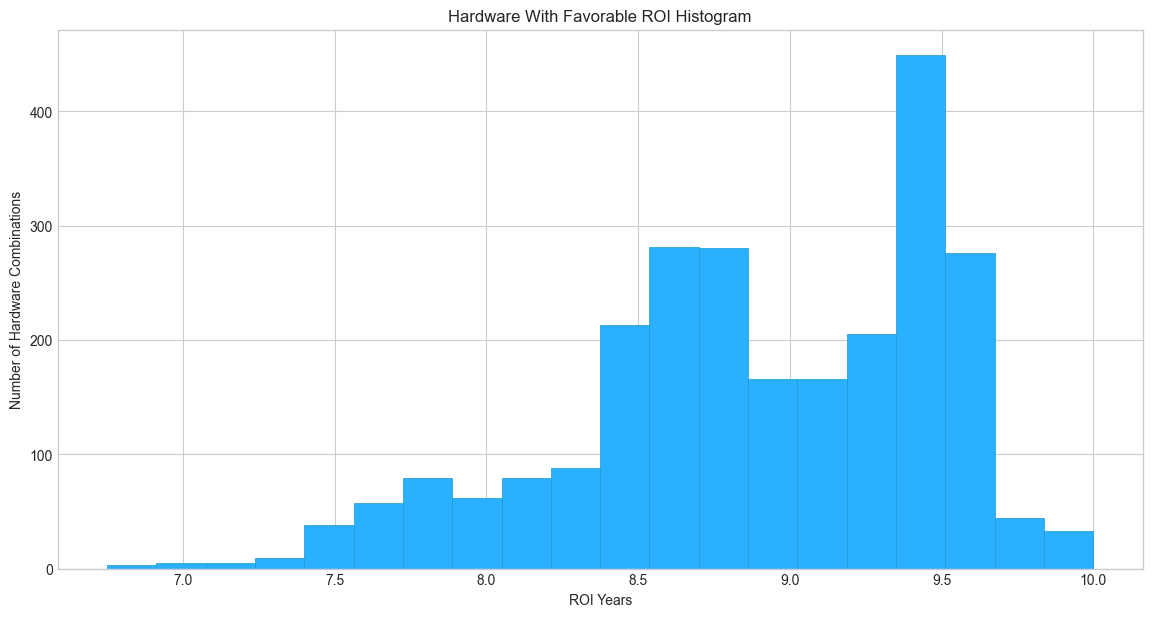

In [83]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['realRoi'], bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


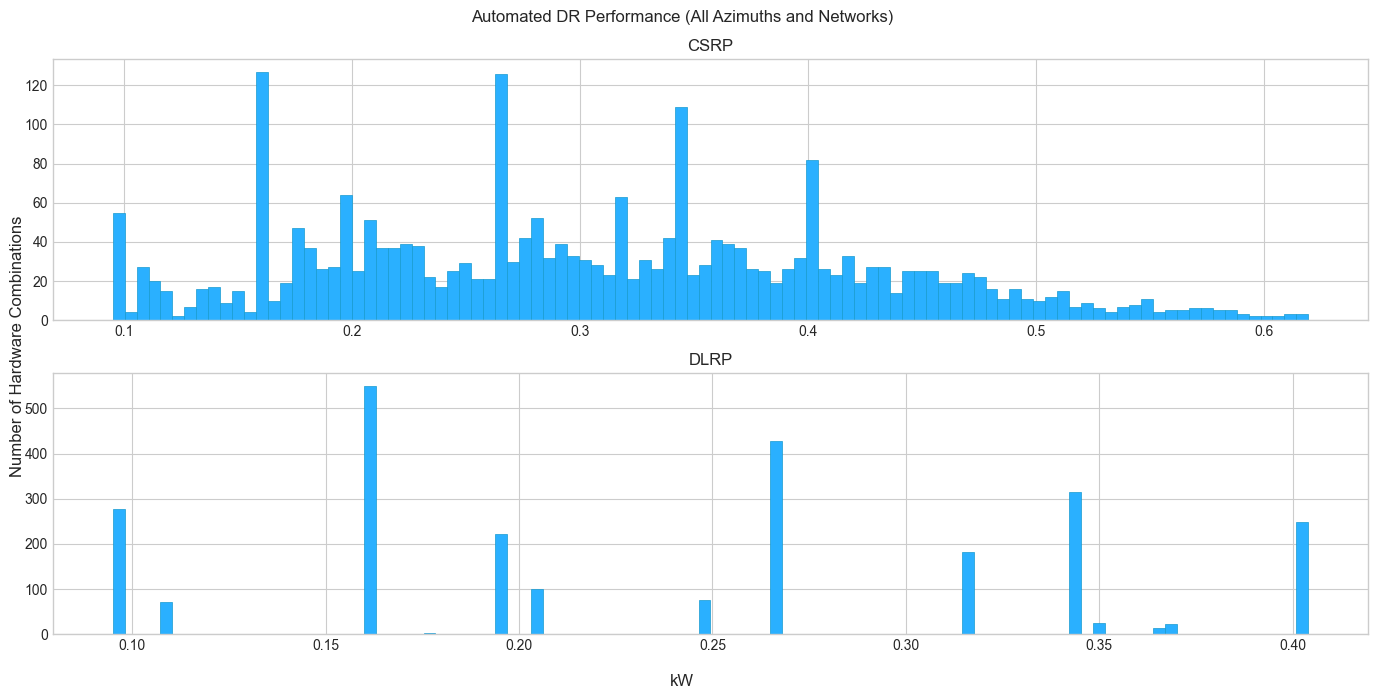

In [84]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(14, 7))
fig.suptitle('Automated DR Performance (All Azimuths and Networks)') 

ax1.hist(favROI_df_Z['avgMAPw_C'] *0.001, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
ax1.set_title("CSRP")
ax2.hist(favROI_df_Z['avgMAPw_D'] *0.001, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
ax2.set_title("DLRP")

#ax1.set(xlabel='kW',ylabel="Number of Hardware Combinations")
#ax2.set(xlabel='kW',ylabel="Number of Hardware Combinations")

fig.supxlabel('kW')
fig.supylabel('Number of Hardware Combinations')

#fig.set(ylabel='Number of Hardware Combinations')

fig.subplots_adjust(bottom=0, top=1.5)

fig.tight_layout(pad=1.0)
#fig.style.use('seaborn-whitegrid') # nice and clean grid
#ax1.xlabel('Max Auto kW') 
fig.show()


<AxesSubplot:title={'center':'Hardware Combinations'}, xlabel='Battery Wh', ylabel='PV Array W'>

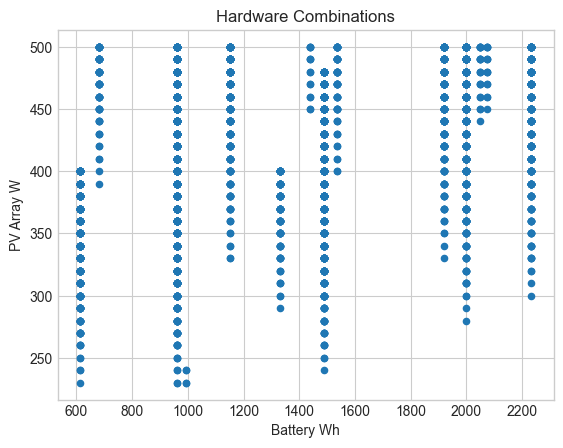

In [85]:
#hardare combos
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW',title='Hardware Combinations',xlabel="Battery Wh",ylabel="PV Array W")


# Analysis

To analize:
* impact of network characteristics
* time and overall quantity
* relationship between azimuth and time

## Overall - Zero Immediate Events

* Fastest ROI
* Greatest IAR
* Greatest DR impact
* Greatest PV generation DC
* Greatest avoided grid energy

In [86]:
snapShot(favROI_df_Z)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.73585068601099
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.616891738722108
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 6.75yrs
Mean ROI: 8.904879169950092
Median ROI: 8.916666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $531.9751963303288 ($55.47741333159144/per year for 9.58904109589041 years)
Mean IROI: 120.90059681081111
Median IROI: 100.35477310356036
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $55.47741333159144
Mean IAR Split: 12.591874901581706
Median IAR Split: 10.431881048935647
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[230, 960.0]', '[230, 614.0]', '[230, 992.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2000.0]', '[500, 2048.0]', '[500, 1920.0]', '[500, 2232.0]', '[500, 1536.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 1440.0]', '[500, 680.96]', '[500, 2073.0]'}
mean P

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Amount with 0 IAR: 245


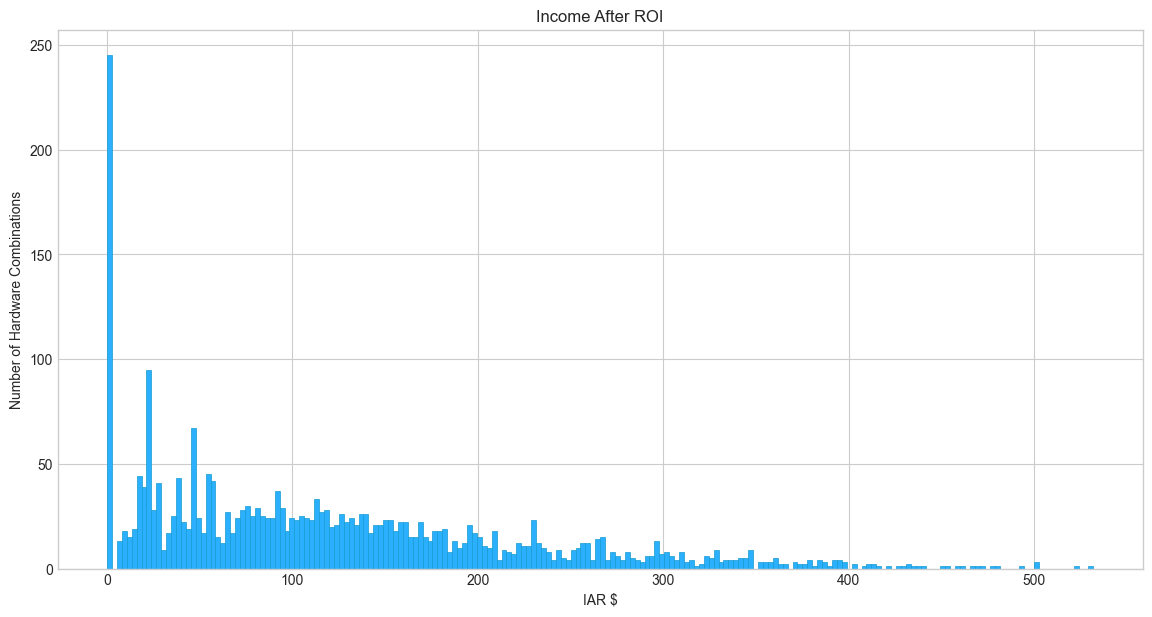

In [87]:
print('Amount with 0 IAR: ' + str(favROI_df_Z[favROI_df_Z['incomeAfterRoi'] == 0].shape[0]))
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Income After ROI') 
plt.xlabel('IAR $') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware'}, xlabel='batWh', ylabel='pvW'>

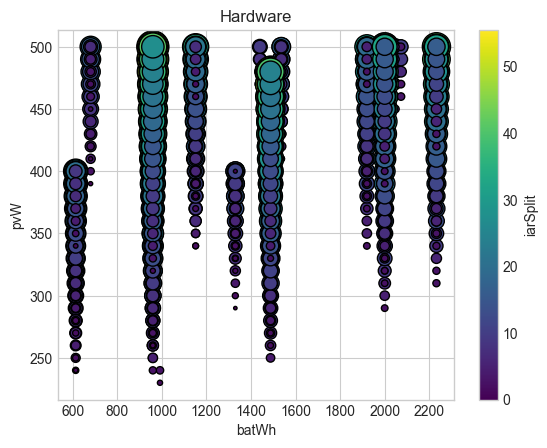

In [88]:
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware')


<AxesSubplot:title={'center':'Hardware w/ IAR >= $300'}, xlabel='batWh', ylabel='pvW'>

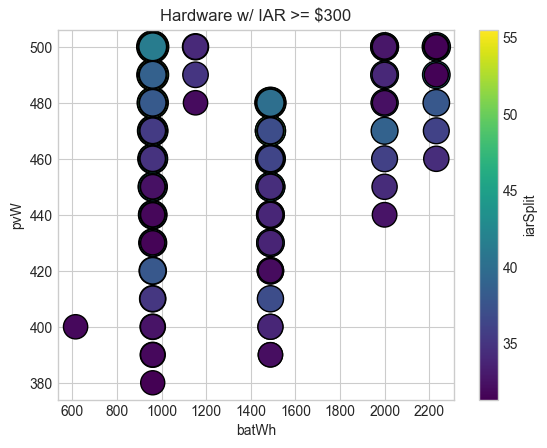

In [89]:
# High IAR

highIAR = favROI_df_Z[favROI_df_Z['incomeAfterRoi'] >= 300]

highIAR.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='iarSplit',s='incomeAfterRoi',colormap='viridis',edgecolor='black', title='Hardware w/ IAR >= $300')

# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(highIAR['incomeAfterRoi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Income After ROI ($0 IAR not shown)') 
# plt.xlabel('IAR $') 
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

In [90]:
#levelized cost compaprison
#https://www.statista.com/statistics/493797/estimated-levelized-cost-of-energy-generation-in-the-us-by-technology/
#2023 commercial solar + store lcoe: $46-102/ per megawatts

# Load Alignment

How do the systems that result from the model match the static loads?

In [91]:
#min, max, mean, median
#favROI_df_Z['dailyPVWAC_4M']

maxPVWAC = []
for m in range(favROI_df_Z.shape[0]):
    maxPVWAC.append(favROI_df_Z['dailyPVWAC_4M'].iloc[m][1])

favROI_df_Z['dailyPVWAC_4M_MAX'] = maxPVWAC

print("percentage of systems under fridge threshold: " + str(favROI_df_Z[favROI_df_Z['dailyPVWAC_4M_MAX']<=2400].shape[0]/favROI_df_Z.shape[0]))

#favROI_df_Z[favROI_df_Z['dailyPVWAC_4M_MAX']>2400]

percentage of systems under fridge threshold: 0.5354609929078015


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [92]:
noCurtailment_df = favROI_df_Z[favROI_df_Z['dailyPVWAC_4M_MAX']<=2400]

snapShot(noCurtailment_df)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.804751680828971
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.623514469745077
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 7.333333333333333yrs
Mean ROI: 9.036607799852833
Median ROI: 9.166666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $385.230979208737 ($40.1740878317683/per year for 9.58904109589041 years)
Mean IROI: 85.93877688009377
Median IROI: 72.57204920286028
Lowest IAR: $0.0 ($0.0/per year for 9.58904109589041 years)

Greatest IAR Split: $40.1740878317683
Mean IAR Split: 8.94363244175862
Median IAR Split: 7.554171557011124
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[230, 960.0]', '[230, 614.0]', '[230, 992.0]'}
Combinations with Maximum PV Arrays: 
{'[450, 680.96]', '[450, 1920.0]', '[450, 1536.0]'}
mean PV: 362.3988226637233
median PV: 370.0

Combinations with Minimum Bat Wh: 
{'[340, 614.0]', '[360, 

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [93]:
snapShot(favROI_df_Z[favROI_df_Z['dailyPVWAC_4M_MAX']>2400])

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.65643045534293
Median Lifespan: 9.58904109589041
Max Lifespan: 10.95890410958904

Min working life: 9.58904109589041
Mean working life: 9.609257903726165
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 6.75yrs
Mean ROI: 8.753039298840825
Median ROI: 8.75
Slowest ROI: 10.0yrs

Greatest IAR: $531.9751963303288 ($55.47741333159144/per year for 9.58904109589041 years)
Mean IROI: 161.20009917369904
Median IROI: 148.38492727579347
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $55.47741333159144
Mean IAR Split: 16.79710094305717
Median IAR Split: 15.455350527725232
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[410, 2232.0]', '[410, 1488.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2000.0]', '[500, 2048.0]', '[500, 1920.0]', '[500, 2232.0]', '[500, 1536.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 1440.0]', '[500, 680.96]', '[500, 2073.0]'}
mean PV: 465.7336726039016
median 

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Impact of Network Characteristics

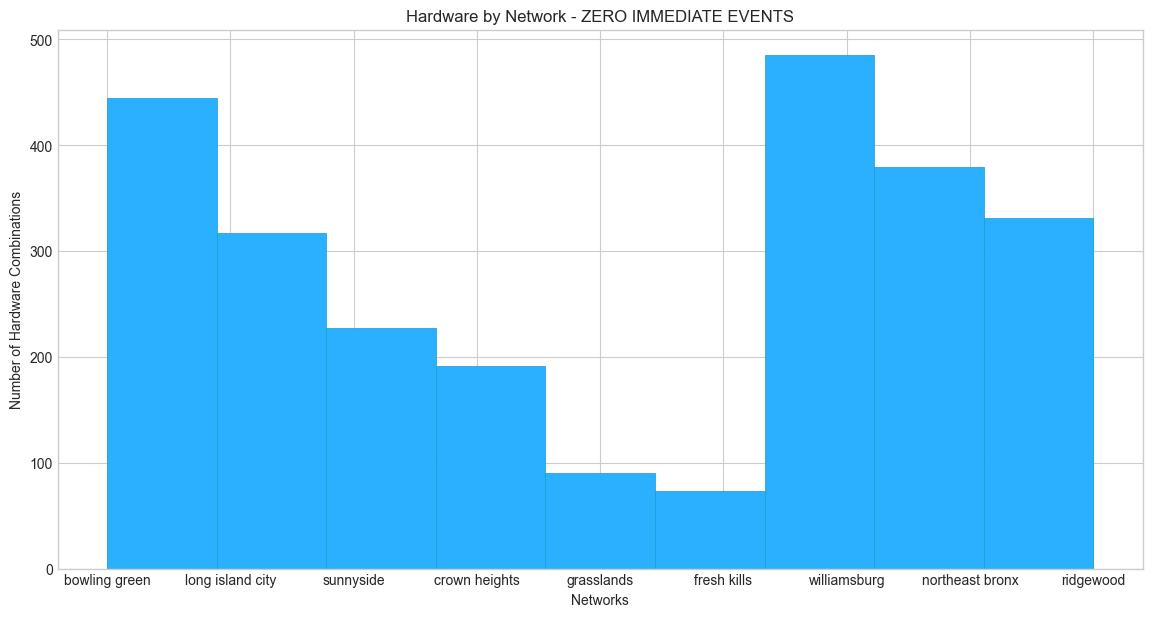

In [94]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df_Z['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware by Network - ZERO IMMEDIATE EVENTS') 
plt.xlabel('Networks') 
#plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
plt.ylabel('Number of Hardware Combinations') 
plt.show()

In [95]:
# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(favROI_df_O['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Hardware by Network - ONE IMMEDIATE EVENTS') 
# plt.xlabel('Networks') 
# #plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

In [96]:
# plt.figure(figsize=(14,7)) # Make it 14x7 inch
# plt.style.use('seaborn-whitegrid') # nice and clean grid
# plt.hist(favROI_df_F['network'], bins=9, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
# plt.title('Hardware by Network - FIVE IMMEDIATE EVENTS') 
# plt.xlabel('Networks') 
# #plt.xticks(str(favROI_df_Z['network'])+ ' ' +str(favROI_df_Z['eventStart']))
# plt.ylabel('Number of Hardware Combinations') 
# plt.show()

<AxesSubplot:title={'center':'ROIs'}, xlabel='realRoi', ylabel='eventStart'>

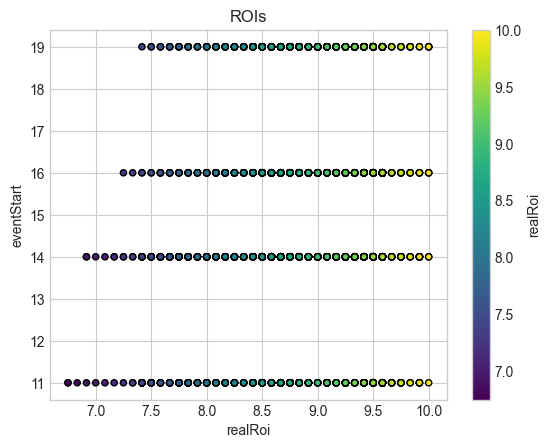

In [97]:
favROI_df_Z.plot(kind = 'scatter', x = 'realRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='ROIs')


In [98]:
#build a data frame with characteristics by neighborhood

nFavorable = {
    "name":[],
    "total amount":[],
    "start time":[],
    "dr rate $":[],
    "min PV":[],
    "min PV bat Wh":[], #the battery that pairs with the min PV module
    "max PV":[],
    "max PV bat Wh":[], #the battery that pairs with the max PV module
    "min bat":[],
    "min bat PV W":[], #the PV modules that pair with the min battery
    "max bat":[],
    "max bat PV W":[], #the PV modules that pair with the max battery
    "bat models":[],
    "min capex":[],
    "max capex":[],
    #avg capex is kind of meaningless,
    #because lower call times have both cheaper and most expensive system,
    #so just a wider range of possibilities
    "avg capex":[], 
    "min ROI":[],
    "max ROI":[],
    "avg ROI":[],
    "min IAR":[],
    "max IAR":[],
    "avg IAR":[],
    "min DR":[],
    "max DR":[],
    "avg DR":[]
}
for n in myNetworks:
    tNAz = favROI_df_Z[favROI_df_Z['network'] == n]
    tN = tNAz#[tNAz['az'] == 180] #uncomment to filter by azimuth
    nFavorable['name'].append(n)
    
    nFavorable['start time'].append(getStartTime(n))
    nFavorable['dr rate $'].append(getTotalRate(n))
    
    if tN.shape[0] != 0:
        nFavorable['total amount'].append(tN.shape[0])
    
        #min PV
        tNminMax = tN[tN['pvW'] == min(tN['pvW'])]
        nFavorable['min PV'].append(min(tN['pvW']))
        nFavorable['min PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #max PV
        tNminMax = tN[tN['pvW'] == max(tN['pvW'])]
        nFavorable['max PV'].append(max(tN['pvW']))
        nFavorable['max PV bat Wh'].append(list(set(tNminMax['batWh'])))

        #min BAT
        tNminMax = tN[tN['batWh'] == min(tN['batWh'])]
        nFavorable['min bat'].append(min(tN['batWh']))
        nFavorable['min bat PV W'].append(list(set(tNminMax['pvW'])))

        #max BAT
        tNminMax = tN[tN['batWh'] == max(tN['batWh'])]
        nFavorable['max bat'].append(max(tN['batWh']))
        nFavorable['max bat PV W'].append(list(set(tNminMax['pvW'])))

        nFavorable['bat models'].append(tN['batModel'].unique())
        
        nFavorable['min capex'].append(min(tN['capex']))
        nFavorable['max capex'].append(max(tN['capex']))
        nFavorable['avg capex'].append(tN['capex'].mean())
        nFavorable['min ROI'].append(min(tN['realRoi']))
        nFavorable['max ROI'].append(max(tN['realRoi']))
        nFavorable['avg ROI'].append(tN['realRoi'].mean())
        
        nFavorable['min IAR'].append(min(tN['incomeAfterRoi']))
        nFavorable['max IAR'].append(max(tN['incomeAfterRoi']))
        nFavorable['avg IAR'].append(tN['incomeAfterRoi'].mean())

        mDR = []
        for y in range(len(tN['avgAutoParticipationAnnualW_C'])):
            #print(list(tN['avgAutoParticipationAnnualW_C']))
            yC = sum(list(tN['avgAutoParticipationAnnualW_C'])[y])
            yD = sum(list(tN['avgAutoParticipationAnnualW_D'])[y])
            mDR.append(sum([yC,yD])/len(list(tN['avgAutoParticipationAnnualW_C'])[y]))

        nFavorable['min DR'].append(min(mDR))
        nFavorable['max DR'].append(max(mDR))
        nFavorable['avg DR'].append(sum(mDR)/len(mDR))
    else:
        for k in ['total amount','min PV','min PV bat Wh','max PV','max PV bat Wh',
                  'min bat','min bat PV W','max bat','max bat PV W', 'bat models',
                  'min capex','max capex','avg capex','min ROI','max ROI',
                  'avg ROI','min IAR','max IAR','avg IAR','min DR','max DR','avg DR']:
            nFavorable[k].append(0)

networkResults_df = pd.DataFrame.from_dict(nFavorable)
display(networkResults_df)

,name,total amount,start time,dr rate $,min PV,min PV bat Wh,max PV,max PV bat Wh,min bat,min bat PV W,...,avg capex,min ROI,max ROI,avg ROI,min IAR,max IAR,avg IAR,min DR,max DR,avg DR
0,bowling green,445,11,36,230,"[992.0, 614.0, 960.0]",500,"[1536.0, 1152.0, 1920.0, 1440.0, 2048.0, 960.0...",614.0,"[320, 290, 260, 390, 230, 360, 330, 300, 270, ...",...,1425.440310,6.750000,10.000000,8.781461,0.0,531.975196,145.190439,279.396487,1023.714637,641.485403
1,long island city,317,14,36,260,"[960.0, 614.0]",500,"[1536.0, 1152.0, 1920.0, 1440.0, 2048.0, 960.0...",614.0,"[320, 290, 260, 390, 360, 330, 300, 270, 400, ...",...,1399.575772,7.166667,10.000000,8.895373,0.0,450.747326,120.770387,232.276224,953.530251,564.518820
2,sunnyside,227,16,36,280,"[960.0, 614.0]",500,"[1536.0, 1152.0, 1920.0, 960.0, 680.96, 2000.0...",614.0,"[320, 290, 390, 360, 330, 300, 400, 370, 340, ...",...,1376.621271,7.500000,9.916667,8.997430,0.0,372.148596,99.389991,200.168645,862.538584,491.657875
3,crown heights,191,19,36,290,"[960.0, 614.0]",500,"[1536.0, 1152.0, 1920.0, 960.0, 680.96, 2000.0...",614.0,"[320, 290, 390, 360, 330, 300, 400, 370, 340, ...",...,1367.064008,7.583333,10.000000,9.047557,0.0,347.991612,90.401936,189.878184,808.084292,458.481644
4,grasslands,90,14,24,310,[614.0],500,"[680.96, 2000.0, 1152.0, 960.0]",614.0,"[320, 390, 360, 330, 400, 370, 340, 310, 380, ...",...,1232.746059,7.833333,9.916667,9.062037,0.0,290.516156,78.660448,241.821450,796.209288,456.111134
5,fresh kills,73,16,24,320,[614.0],500,"[1152.0, 2000.0, 960.0]",614.0,"[320, 390, 360, 330, 400, 370, 340, 380, 350]",...,1222.725858,8.000000,9.583333,9.102740,0.0,263.019285,71.686935,202.363688,718.650334,382.930916
6,williamsburg,485,14,43,230,"[992.0, 960.0]",500,"[1536.0, 1152.0, 1920.0, 1440.0, 2048.0, 960.0...",614.0,"[320, 290, 260, 390, 360, 330, 300, 270, 400, ...",...,1447.941383,6.916667,10.000000,8.810653,0.0,500.954158,143.108556,229.096099,953.530251,590.896527
7,northeast bronx,379,16,43,250,"[1488.0, 960.0]",500,"[1536.0, 1152.0, 1920.0, 1440.0, 2048.0, 960.0...",614.0,"[320, 290, 260, 390, 360, 330, 300, 270, 400, ...",...,1436.228125,7.250000,10.000000,8.923923,0.0,435.466052,120.090495,199.295514,862.538584,532.461151
8,ridgewood,331,19,43,260,"[1488.0, 960.0]",500,"[1536.0, 1152.0, 1920.0, 2048.0, 960.0, 680.96...",614.0,"[320, 290, 390, 360, 330, 300, 270, 400, 370, ...",...,1432.309317,7.416667,10.000000,8.963998,0.0,396.971074,111.446904,189.878184,808.084292,506.156427


In [99]:
#which power station models are viable?
listModels = []

for n in range(networkResults_df.shape[0]):
    listModels.extend(list(networkResults_df.iloc[n]['bat models']))
    
setModels = set(listModels)
print(len(setModels))

modelCount = {}
for m in setModels:
    modelCount[m]= listModels.count(m)
    
display(modelCount)

15


{'E2000LFP Expandable': 7,
 'E1500LFP Expandable': 7,
 'Mega 2': 5,
 '1800 Portable Power Station': 9,
 'P2001': 9,
 'AC200P': 5,
 '1200 Portable Power Station': 2,
 'DBS1300': 7,
 'AC180': 9,
 'E600LFP': 9,
 'Explorer 700 Plus': 8,
 'P1201': 9,
 'ST2000': 4,
 '2400 Portable Power Station': 7,
 'AC180P': 4}

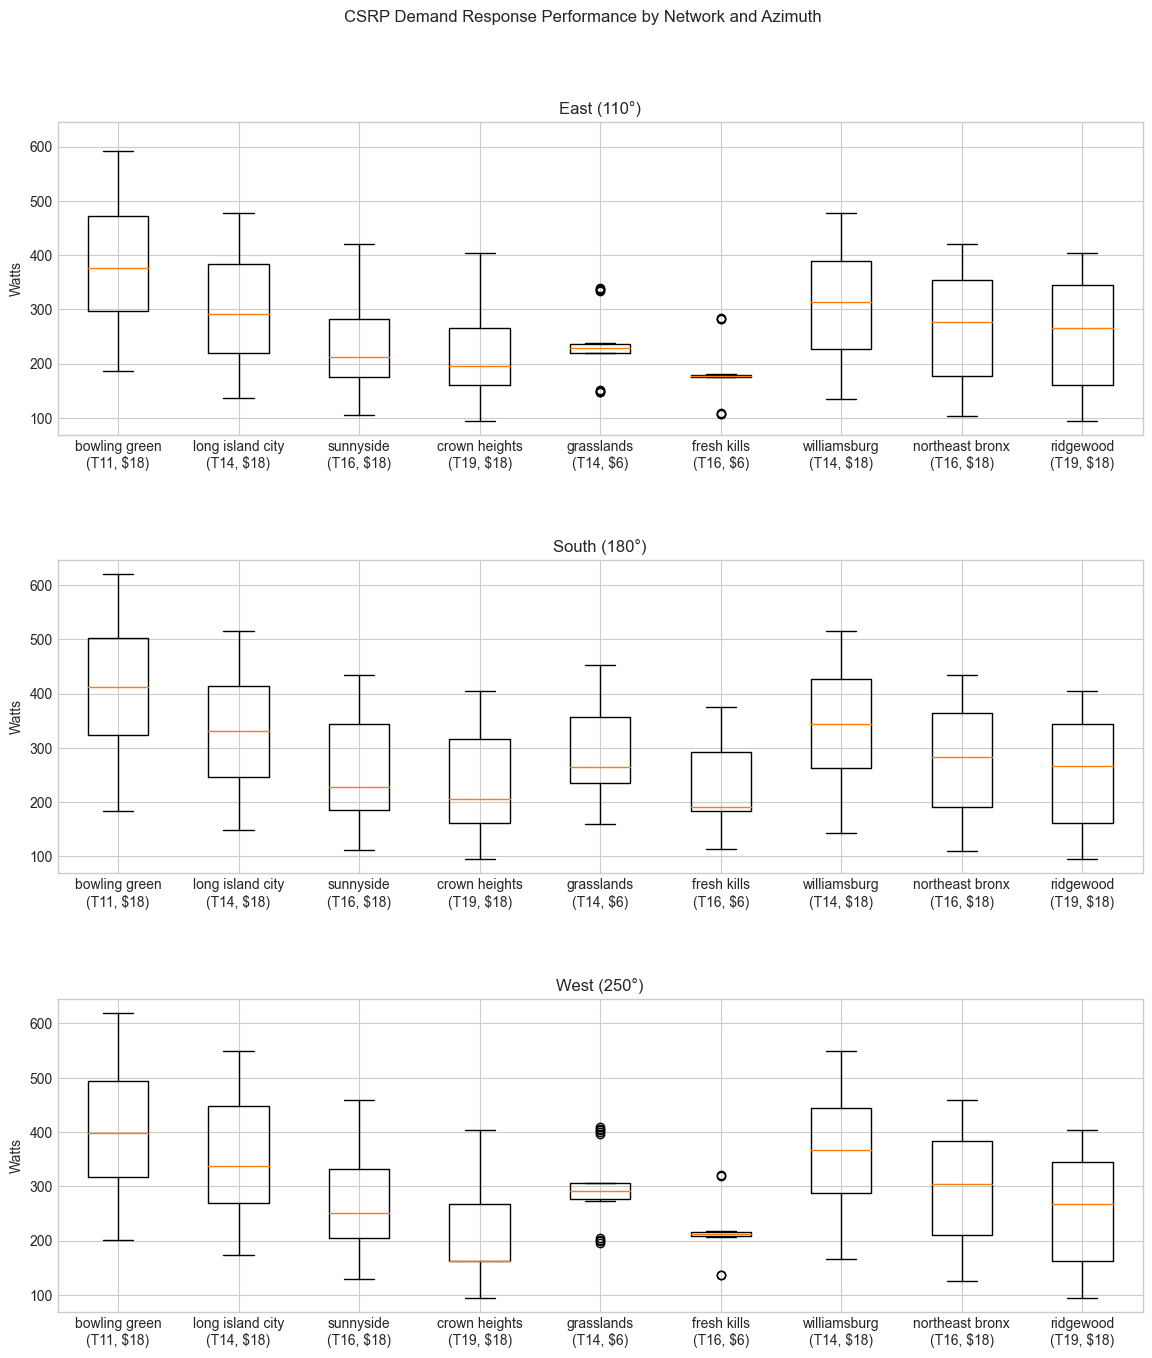

In [100]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getCSRPrate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_C']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('CSRP Demand Response Performance by Network and Azimuth')
    
plt.show()


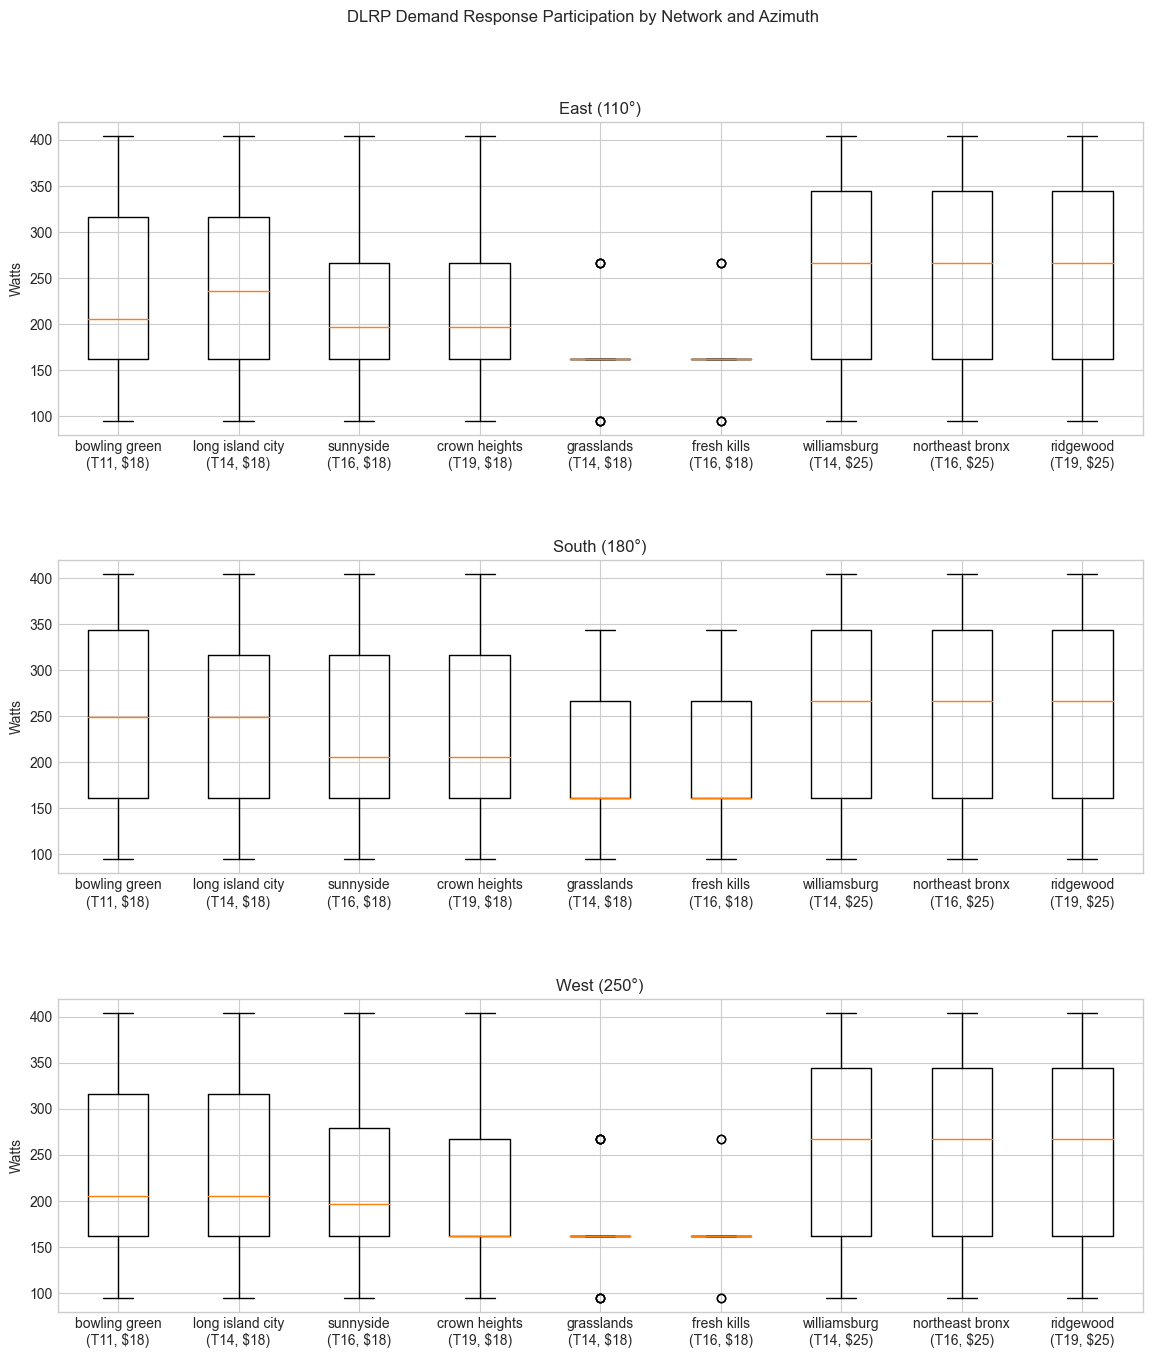

In [101]:
#box plot for DR, ROI, IAR... is there a way to represent a box plot for multidimension data? i.e pairs of PV and Bat specs? 

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['az'] == 180][favROI_df_Z[favROI_df_Z['az'] == 180]['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getDLRPrate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['avgMAPw_D']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('DLRP Demand Response Participation by Network and Azimuth')
    
plt.show()


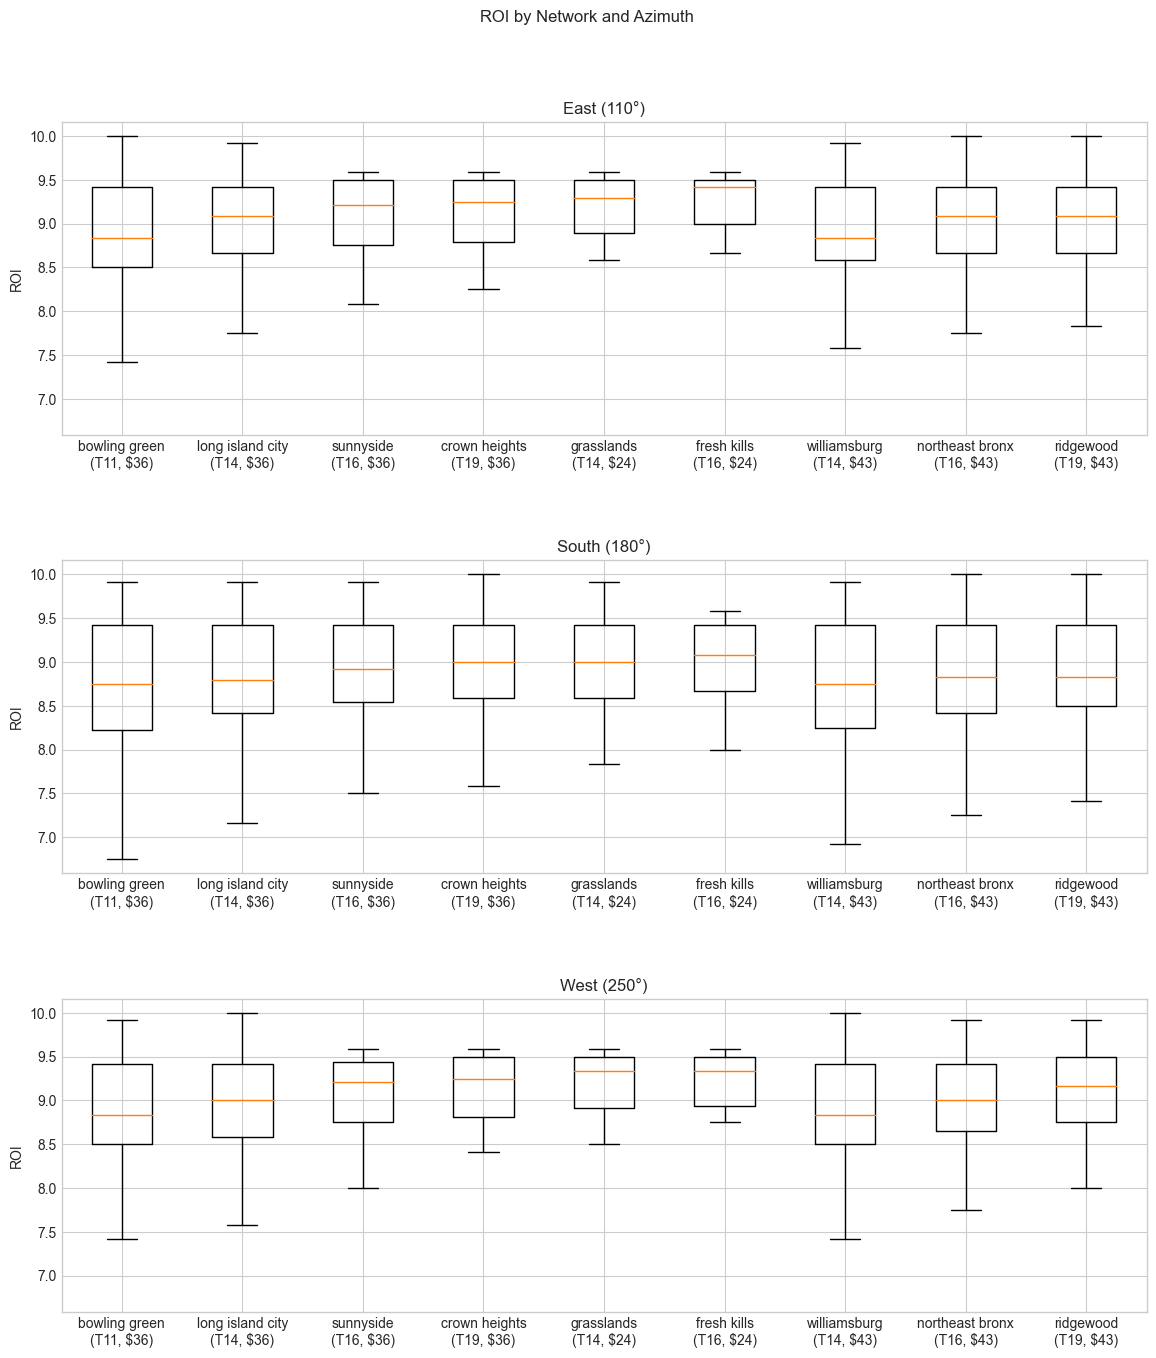

In [102]:
#box plot for ROI

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['realRoi']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('ROI') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('ROI by Network and Azimuth')
    
plt.show()


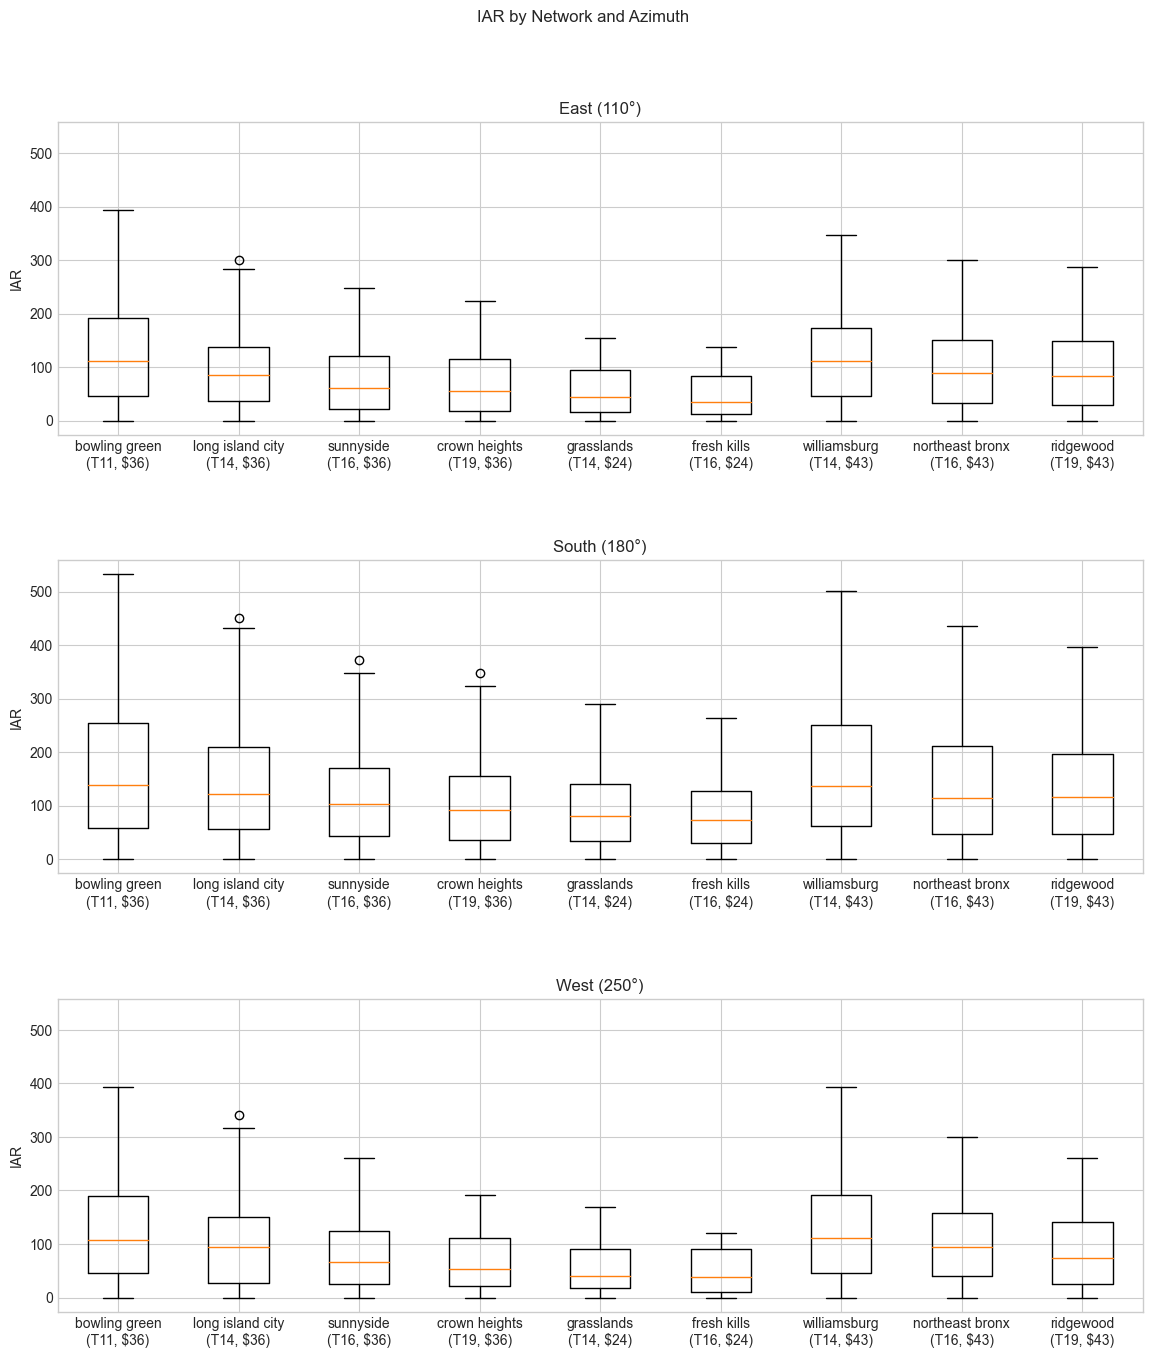

In [103]:
#box plot for IAR

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['incomeAfterRoi']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('IAR') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('IAR by Network and Azimuth')
    
plt.show()


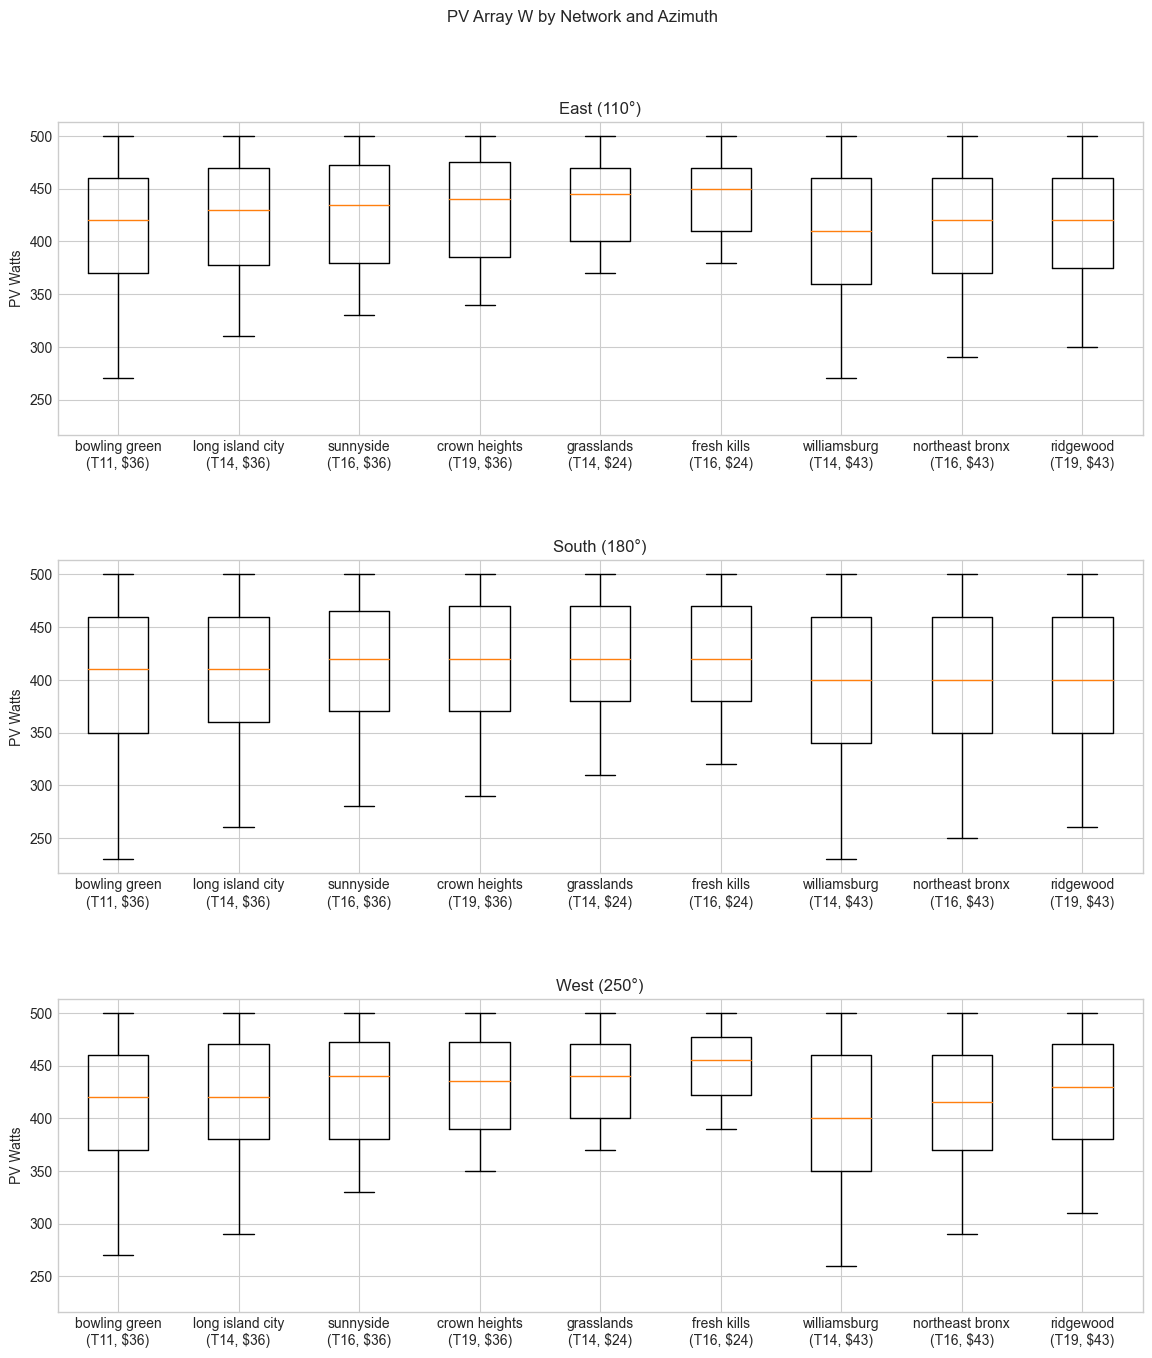

In [104]:
#box plot for IAR

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['pvW']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('PV Watts') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('PV Array W by Network and Azimuth')
    
plt.show()

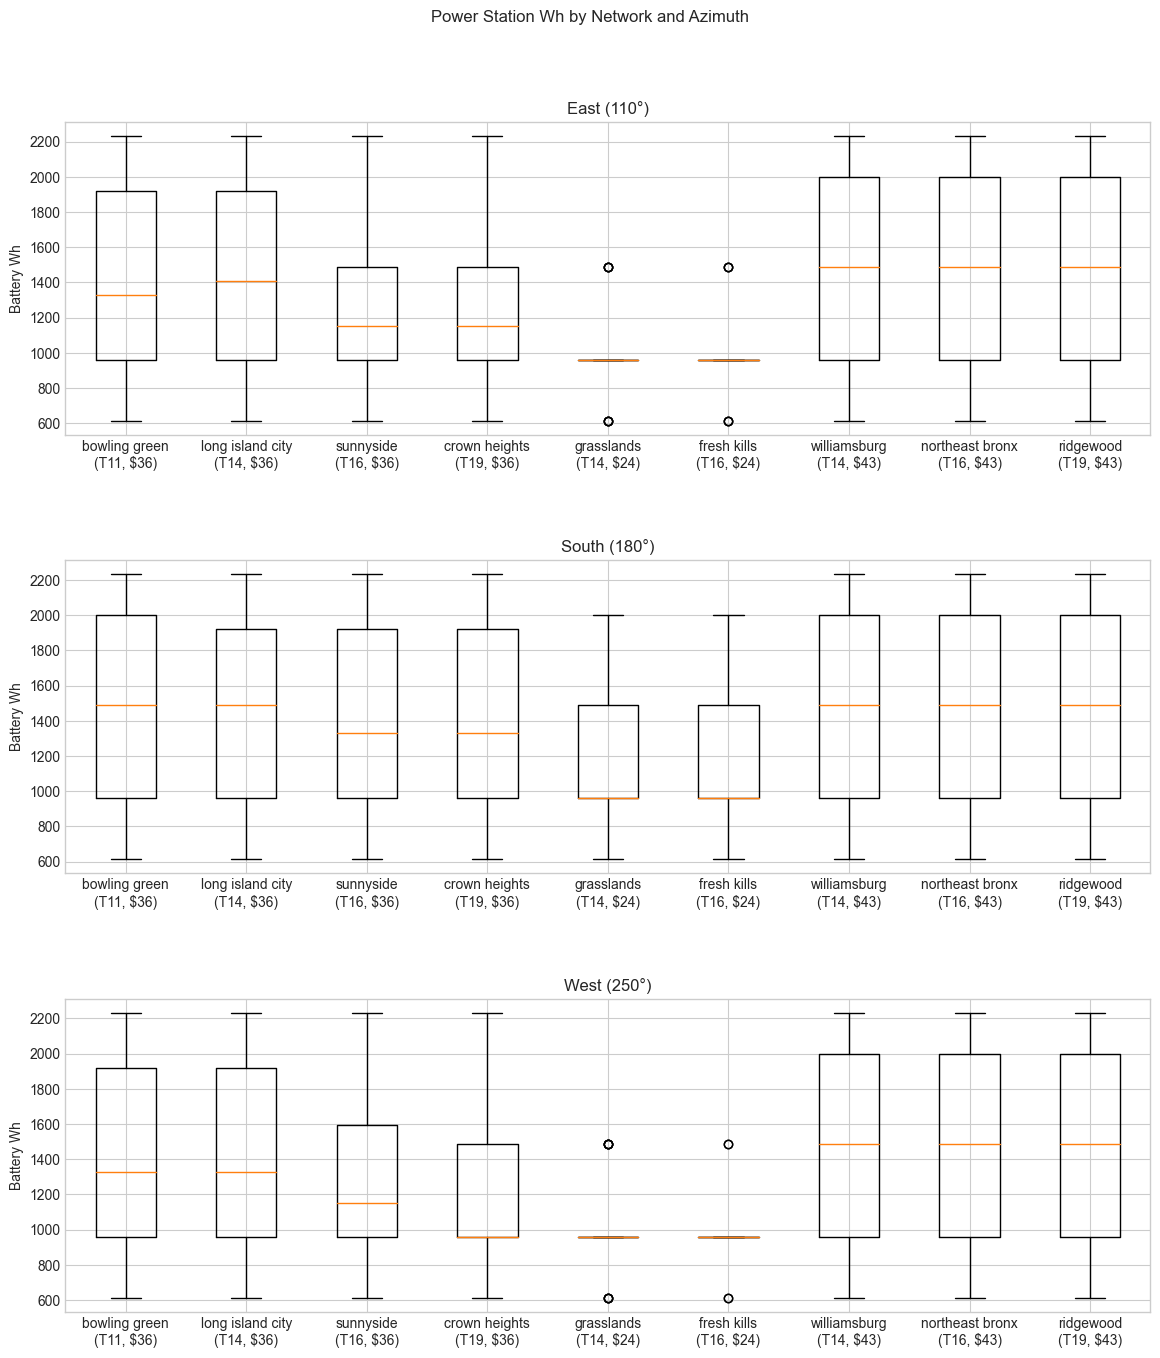

In [105]:
#box plot for IAR

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
myLabels=[]
for n in myNetworks:
    mN = favROI_df_Z[favROI_df_Z['network'] == n]
    myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    bPD = favROI_df_Z[favROI_df_Z['az'] == azi[a]]
    
    boxPlotData = []
    for n in myNetworks:
        bP = bPD[bPD['network'] == n]
        boxPlotData.append(list(bP['batWh']))

    axs[a].boxplot(boxPlotData, labels=myLabels)
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('Battery Wh') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('Power Station Wh by Network and Azimuth')
    
plt.show()

<AxesSubplot:title={'center':'Auto Participation CSRP'}, xlabel='avgMAPw_C', ylabel='eventStart'>

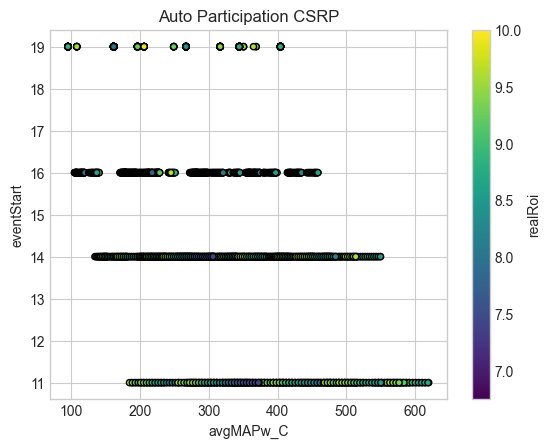

In [106]:
favROI_df_Z.plot(kind = 'scatter', x = 'avgMAPw_C', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Auto Participation CSRP')


<AxesSubplot:title={'center':'Auto Participation DLRP'}, xlabel='avgMAPw_D', ylabel='eventStart'>

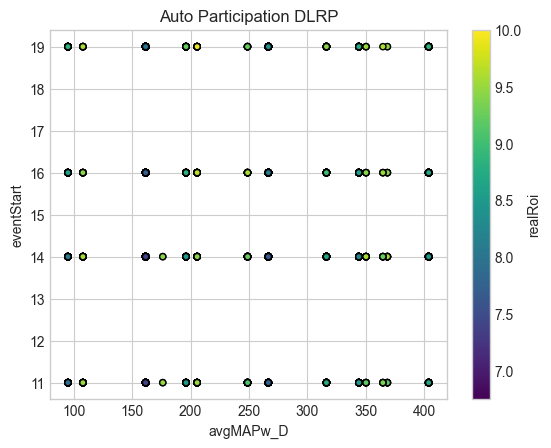

In [107]:
favROI_df_Z.plot(kind = 'scatter', x = 'avgMAPw_D', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Auto Participation DLRP')


<AxesSubplot:title={'center':'Income After ROI'}, xlabel='incomeAfterRoi', ylabel='eventStart'>

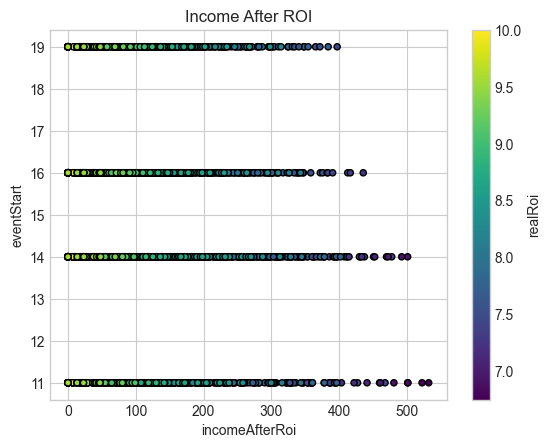

In [108]:
favROI_df_Z.plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'eventStart', c='realRoi',edgecolor='black',colormap='viridis', title='Income After ROI')


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

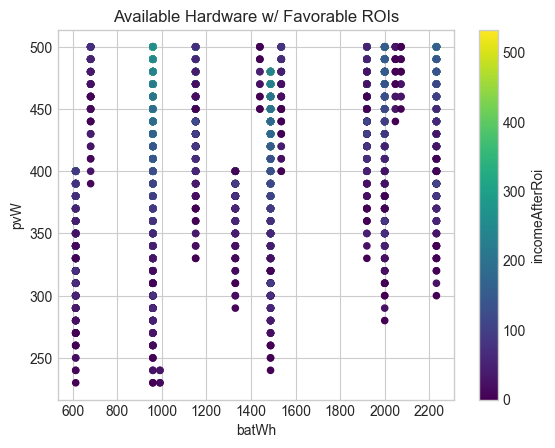

In [109]:
favROI_df_Z.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


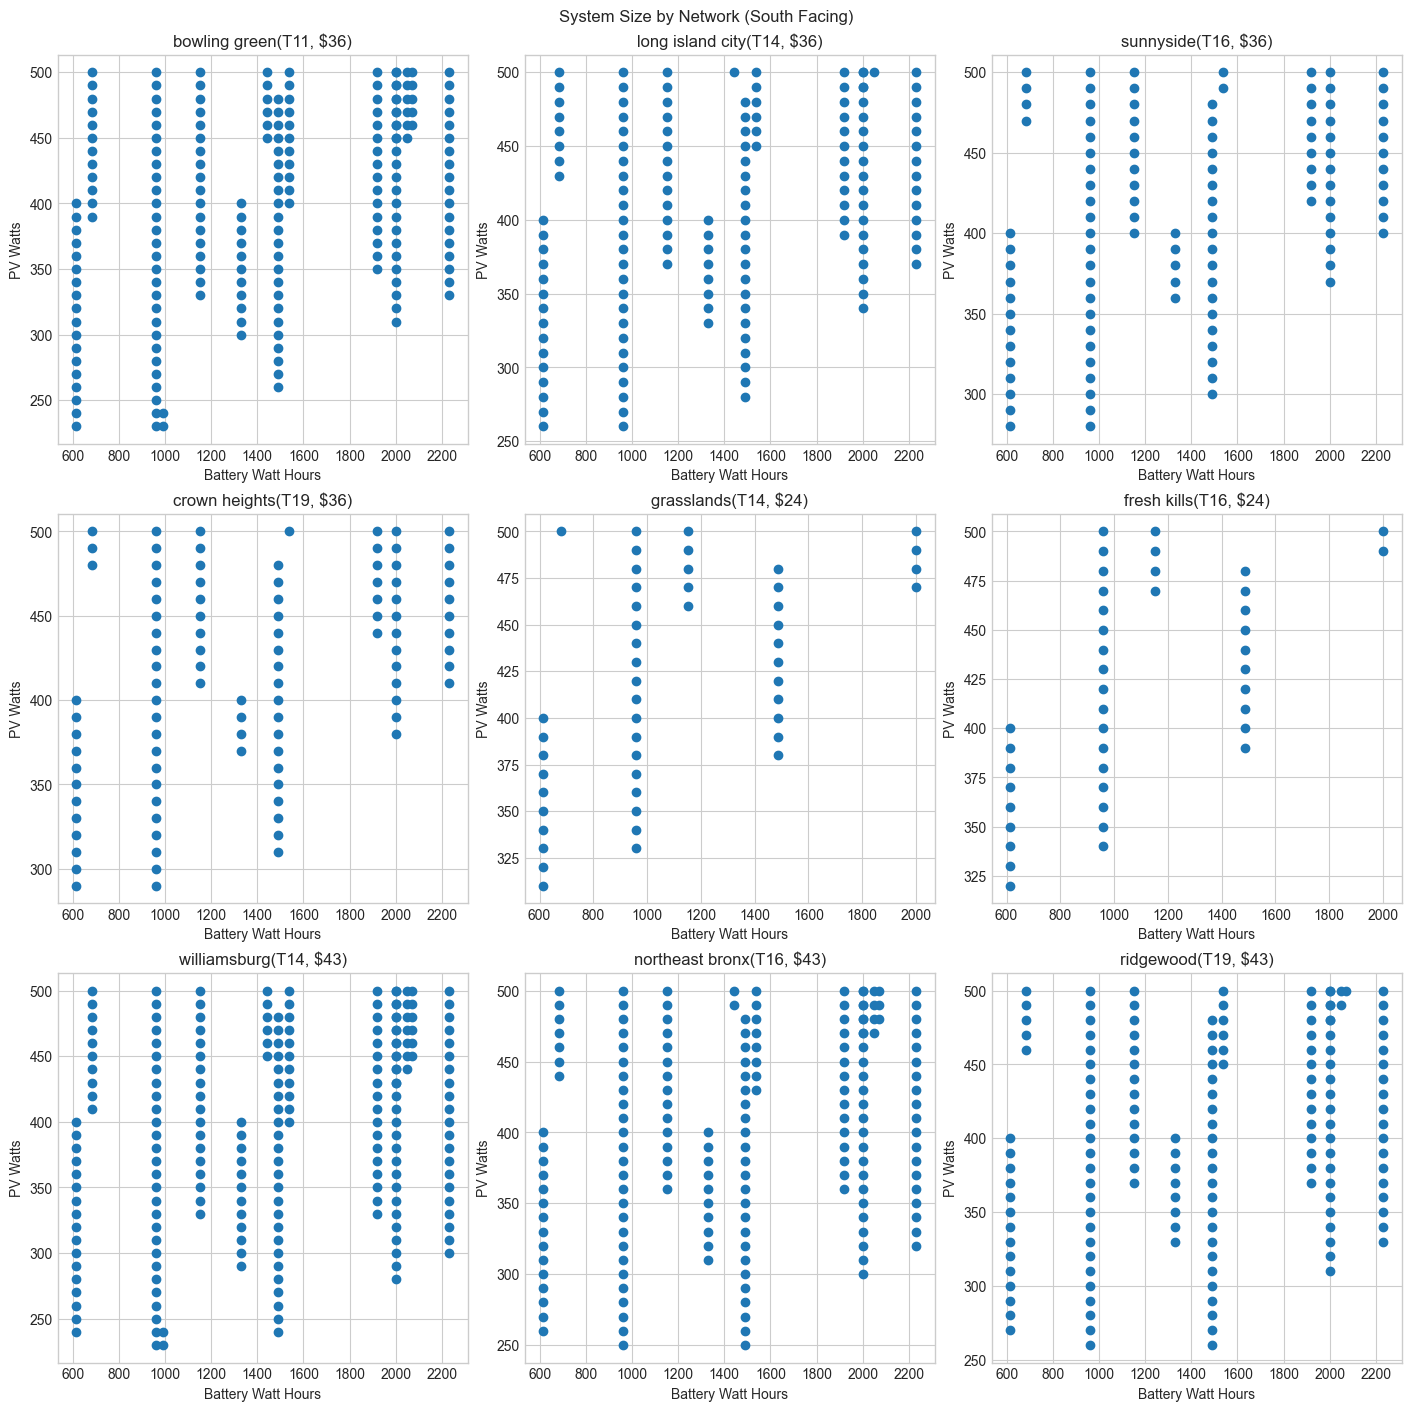

In [110]:
#hardware combos by network

fig, axs = plt.subplots(3,3, figsize=(14, 14), layout="constrained")

azi = 180

hc_df = favROI_df_Z[favROI_df_Z['az'] == azi]

myLabels=[]
for n in myNetworks:
    mN = hc_df[hc_df['network'] == n]
    myLabels.append(n + "(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for x in range(3):
    for y in range(3):
        p = y+(3*x)
        n = myNetworks[p]     
        nhc_df = hc_df[hc_df['network'] == n]

        axs[x,y].scatter(x = nhc_df['batWh'], y = nhc_df['pvW'])
        axs[x,y].set_title(myLabels[p])
        axs[x,y].set_ylabel('PV Watts') 
        axs[x,y].set_xlabel('Battery Watt Hours') 

# fig.subplots_adjust(bottom=0.05, top=0.9,
#                     hspace=0.4, wspace=0.3)
fig.suptitle('System Size by Network (South Facing)')
    
plt.show()

In [111]:
# #start time comparison

# fig, axs = plt.subplots(3, 4, figsize=(16, 12), layout="constrained",sharex=True,sharey=True)

# azi = [110,180,250]

# showNetworks = ['bowling green','long island city','sunnyside','crown heights']

# for x in range(3):
#     for y in range(4):
        
#         hc_df = favROI_df_Z[favROI_df_Z['az'] == azi[x]]

#         myLabels=[]
#         for n in showNetworks:
#             mN = hc_df[hc_df['network'] == n]
#             myLabels.append(n + "(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

#         n = showNetworks[y]     
#         nhc_df = hc_df[hc_df['network'] == n]

#         axs[x,y].scatter(x = nhc_df['batWh'], y = nhc_df['pvW'])
#         axs[x,y].set_title(myLabels[y])
#         axs[x,y].set_ylabel('PV Watts') 
#         axs[x,y].set_xlabel('Battery Watt Hours') 

# # fig.subplots_adjust(bottom=0.05, top=0.9,
# #                     hspace=0.4, wspace=0.3)
# fig.suptitle('System Size Time Comparison)')
    
# plt.show()

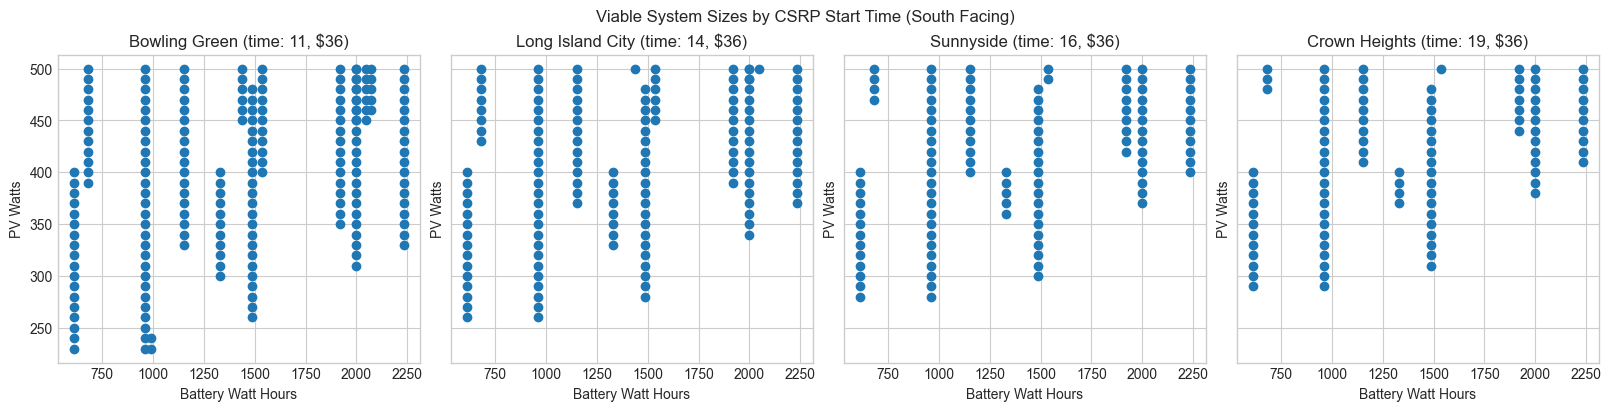

In [145]:
#start time comparison

fig, axs = plt.subplots(1,4, figsize=(16, 4), layout="constrained",sharex=True,sharey=True)

azi = 180
hc_df = favROI_df_Z[favROI_df_Z['az'] == azi]

#showNetworks = ['bowling green','long island city','sunnyside','crown heights']
showNetworksUC = ['Bowling Green','Long Island City','Sunnyside','Crown Heights']

myLabels=[]
for n in showNetworksUC:
    mN = hc_df[hc_df['network'] == n.lower()]
    myLabels.append(n + " (time: "+ str(getStartTime(n.lower())) + ", $" + str(getTotalRate(n.lower())) +")")
        
for y in range(4):

    n = showNetworksUC[y]     
    nhc_df = hc_df[hc_df['network'] == n.lower()]

    axs[y].scatter(x = nhc_df['batWh'], y = nhc_df['pvW'])
    axs[y].set_title(myLabels[y])
    axs[y].set_ylabel('PV Watts') 
    axs[y].set_xlabel('Battery Watt Hours') 

# fig.subplots_adjust(bottom=0.05, top=0.9,
#                     hspace=0.4, wspace=0.3)
fig.suptitle('Viable System Sizes by CSRP Start Time (South Facing)')
    
plt.show()

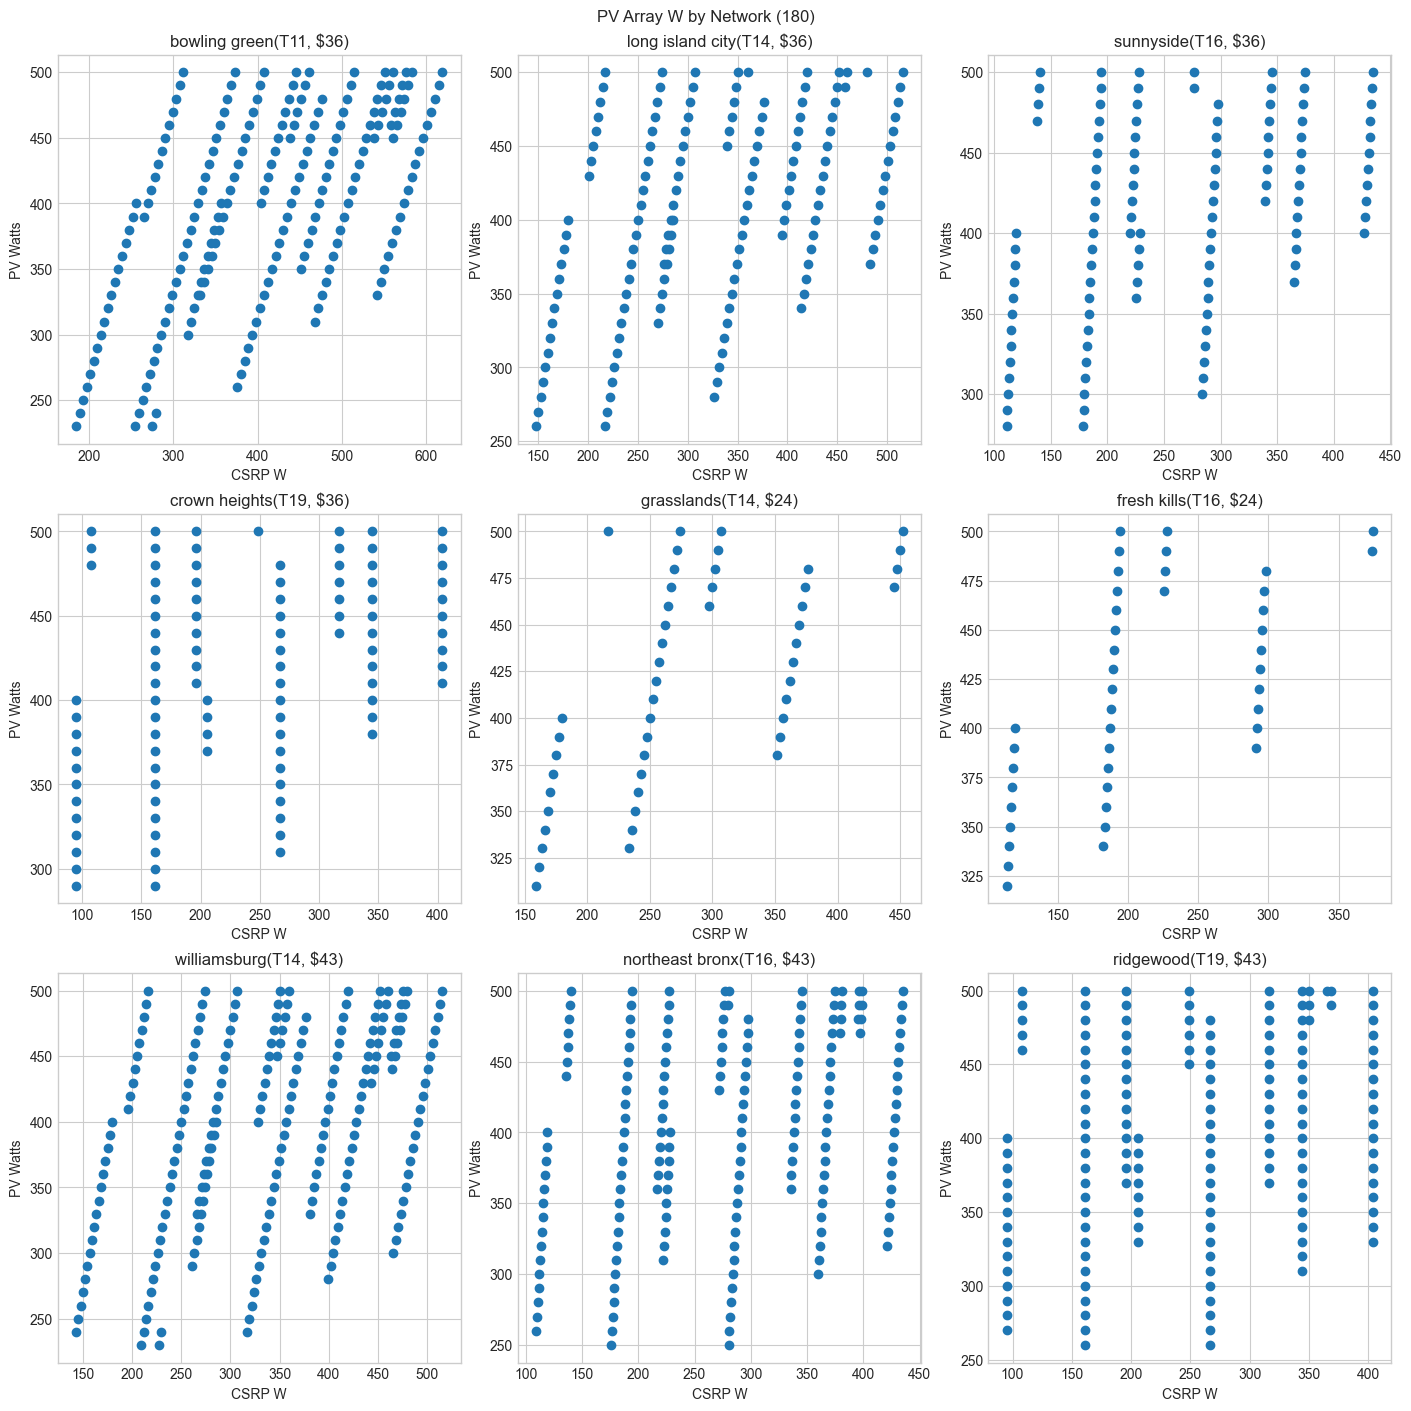

In [113]:
#CSRP vs PV

fig, axs = plt.subplots(3,3, figsize=(14, 14), layout="constrained")

azi = 180

hc_df = favROI_df_Z[favROI_df_Z['az'] == azi]

myLabels=[]
for n in myNetworks:
    mN = hc_df[hc_df['network'] == n]
    myLabels.append(n + "(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for x in range(3):
    for y in range(3):
        p = y+(3*x)
        n = myNetworks[p]     
        nhc_df = hc_df[hc_df['network'] == n]

        axs[x,y].scatter(x = nhc_df['avgMAPw_C'], y = nhc_df['pvW'])
        axs[x,y].set_title(myLabels[p])
        axs[x,y].set_ylabel('PV Watts') 
        axs[x,y].set_xlabel('CSRP W') 

# fig.subplots_adjust(bottom=0.05, top=0.9,
#                     hspace=0.4, wspace=0.3)
fig.suptitle('PV Array W by Network (180)')
    
plt.show()

<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs & high IAR'}, xlabel='batWh', ylabel='pvW'>

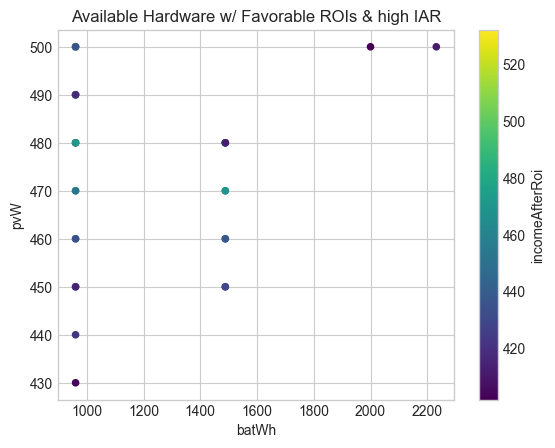

In [114]:
favROI_df_Z[favROI_df_Z['incomeAfterRoi']>=400].plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='incomeAfterRoi',colormap='viridis', title='Available Hardware w/ Favorable ROIs & high IAR')


<AxesSubplot:title={'center':'Relationship between IAR and CSRP Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='avgMAPw_C'>

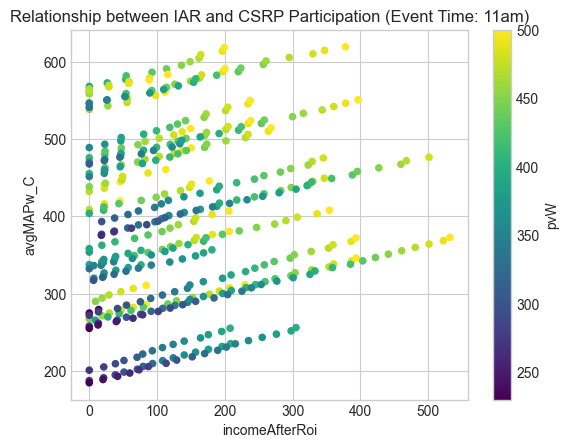

In [115]:
favROI_df_Z[favROI_df_Z['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw_C', c='pvW',colormap='viridis', title='Relationship between IAR and CSRP Participation (Event Time: 11am)')


<AxesSubplot:title={'center':'Relationship between IAR and DLRP Participation (Event Time: 11am)'}, xlabel='incomeAfterRoi', ylabel='avgMAPw_D'>

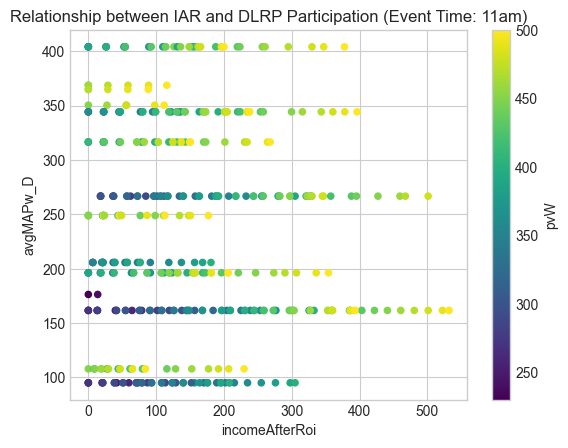

In [116]:
favROI_df_Z[favROI_df_Z['eventStart']==11].plot(kind = 'scatter', x = 'incomeAfterRoi', y = 'avgMAPw_D', c='pvW',colormap='viridis', title='Relationship between IAR and DLRP Participation (Event Time: 11am)')


In [117]:
highParticipation_df = favROI_df_Z[favROI_df_Z['avgMAPw_C']>=400]
highParticipation_df.shape[0]

600

## Unique Systems
Are there particular azimuths and network combos that have unique options or is it only more/less systems?

In [118]:
# favROI_df_Z[favROI_df_Z['avgMAPw_C']
            
            
# for n in myNetworks:    
#         nhc_df = hc_df[hc_df['network'] == n]

#         axs[x,y].scatter(x = nhc_df['avgMAPw_C'], y = nhc_df['pvW'])
#         axs[x,y].set_title(myLabels[p])
#         axs[x,y].set_ylabel('PV Watts') 
#         axs[x,y].set_xlabel('CSRP W') 

## Results for HOMER Validation

In [119]:
#data for validation


# 'E2000LFP Expandable': 7,
#  'P2001': 9,
#  'AC180': 9,
#  'ST2000': 4,
#  '2400 Portable Power Station': 7,
#  'Mega 2': 5,
#  'P1201': 9,
#  'DBS1300': 7,
#  'E1500LFP Expandable': 7,
#  'Explorer 700 Plus': 8,
#  '1800 Portable Power Station': 9,
#  'AC180P': 4,
#  'AC200P': 5,
#  'E600LFP': 9,
#  '1200 Portable Power Station': 2}

#print(favROI_df_Z.keys())
model_df = favROI_df_Z[favROI_df_Z['batModel'] == 'AC180']
model_df = model_df[model_df['pvW']==470]
model_df[['network','az','pvW','avgAutoParticipationAnnualW_C','avgAutoParticipationAnnualW_D']]

,network,az,pvW,avgAutoParticipationAnnualW_C,avgAutoParticipationAnnualW_D
4431,bowling green,110,470,"[377.15000206012104, 375.23323649219316, 373.3...","[196.10772894427728, 196.10772894427728, 196.1..."
4572,bowling green,180,470,"[404.0987050655982, 401.9136247246685, 399.750...","[196.10772894427728, 196.10772894427728, 196.1..."
4713,bowling green,250,470,"[403.14437293140816, 400.9687624946718, 398.81...","[196.10772894427728, 196.10772894427728, 196.1..."
22062,long island city,110,470,"[268.5255596321657, 267.6977139106444, 266.878...","[196.10772894427728, 196.10772894427728, 196.1..."
22203,long island city,180,470,"[305.08355462852916, 303.8899248633385, 302.70...","[196.10772894427728, 196.10772894427728, 196.1..."
22344,long island city,250,470,"[337.26455006644113, 335.74970882836067, 334.2...","[196.10772894427728, 196.10772894427728, 196.1..."
39693,sunnyside,110,470,"[212.65708816757342, 212.42904047842566, 212.2...","[196.10772894427728, 196.10772894427728, 196.1..."
39834,sunnyside,180,470,"[227.06159565077445, 226.6886030084488, 226.31...","[196.10772894427728, 196.10772894427728, 196.1..."
39975,sunnyside,250,470,"[249.69784346645673, 249.09494194206104, 248.4...","[196.10772894427728, 196.10772894427728, 196.1..."
57465,crown heights,180,470,"[196.10772894427728, 196.10772894427728, 196.1...","[196.10772894427728, 196.10772894427728, 196.1..."


In [120]:
model_df = favROI_df_Z[favROI_df_Z['batModel'] == '1200 Portable Power Station']
model_df = model_df[model_df['pvW']==230]
model_df[['network','az','avgAutoParticipationAnnualW_C','avgAutoParticipationAnnualW_D']]

,network,az,avgAutoParticipationAnnualW_C,avgAutoParticipationAnnualW_D
11019,bowling green,180,"[279.6528178927148, 278.5467309688779, 277.451...","[176.18681127208262, 176.18681127208262, 176.1..."
116805,williamsburg,180,"[229.61841551957508, 229.0148363436778, 228.41...","[176.18681127208262, 176.18681127208262, 176.1..."


## Economic Benefit

Percentage of annual economic benefit from DR

In [172]:
eb_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batModel', 'batWh', 'batWhAC',
       'effEff', 'dischargeRateW', 'capex', 'dollarPerBatkWh', 'dailyPVWAC_4M',
       'annualPVkWhDC_degraded', 'annualPVkWhAC_degraded', 'avoidedGridCosts',
       'immediateEventAmt', 'avgAutoParticipationMonthlyW_C',
       'avgAutoParticipationMonthlyW_D', 'avgAutoParticipationAnnualW_C',
       'avgAutoParticipationAnnualW_D', 'avgMAPw_C', 'avgMAPw_D',
       'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D', 'drIncAnnual_C',
       'drIncAnnual_D', 'drPerformanceIncome', 'annualBenefit', 'realRoi',
       'Cycles', 'lifespan', 'workingLife', 'profitableYears',
       'incomeAfterRoi', 'iarSplit', 'totalDR_AnnualAvgInc',
       'dailyPVWAC_4M_MAX'],
      dtype='object')

In [162]:
eb_df = favROI_df_Z[favROI_df_Z['az'] == 180]

eb_df.shape

(1184, 38)

In [171]:
econBenefits = {
    'dlrp_res': list(eb_df['drIncAnnual_D'].apply(lambda x: mean(x))),
    'csrp_res': list(eb_df['drIncAnnual_C'].apply(lambda x: mean(x))),
    'csrp_perf': list(eb_df['drPerformanceIncome'].apply(lambda x: mean(x))),
    'totBene': list(eb_df['annualBenefit'].apply(lambda x: mean(x)))
}

In [176]:
# width = 0.6  # the width of the bars: can also be len(x) sequence


# fig, ax = plt.subplots()
# bottom = [0,0,0,0]

# for source, sourceAmt in econBenefits.items():
#     p = ax.bar(source, sourceAmt, width, label=source, bottom=bottom)
#     bottom += sourceAmt

#     ax.bar_label(p, label_type='center')

# ax.set_title('Number of penguins by sex')
# ax.legend()

# plt.show()

## Impact of Immediate Events

In [177]:
snapShot(favROI_df_Z)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.73585068601099
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.616891738722108
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 6.75yrs
Mean ROI: 8.904879169950092
Median ROI: 8.916666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $531.9751963303288 ($55.47741333159144/per year for 9.58904109589041 years)
Mean IAR: 120.90059681081111
Median IAR: 100.35477310356036
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $55.47741333159144
Mean IAR Split: 12.591874901581706
Median IAR Split: 10.431881048935647
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[230, 960.0]', '[230, 614.0]', '[230, 992.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2000.0]', '[500, 2048.0]', '[500, 1920.0]', '[500, 2232.0]', '[500, 1536.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 1440.0]', '[500, 680.96]', '[500, 2073.0]'}
mean PV:

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Min Avg Annual DR Income: 13.06
Mean Avg Annual DR Income: 56.15
Median Avg Annual DR Income: 54.07
Max Avg Annual DR Income: 106.55

Min Avg Annual Econ Benefits: 81.54
Mean Avg Annual Econ Benefits: 161.7
Median Avg Annual Econ Benefits: 163.06
Max Avg Annual Econ Benefits: 249.09

Mean % of Annual Benefits Contributed by DR: 0.3472538466749802

Min Maximum Daily PV WAC: 1169.647391142932
Max Maximum Daily PV WAC: 3009.145628448419
Mean Maximum Daily PV WAC: 2299.4627215635346
Median Maximum Daily PV WAC: 2366.774218934962


In [178]:
snapShot(favROI_df_O)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.737666041931904
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.61723612241887
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 6.75yrs
Mean ROI: 8.905032575455392
Median ROI: 8.916666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $531.9751963303288 ($55.47741333159144/per year for 9.58904109589041 years)
Mean IAR: 120.7351636442221
Median IAR: 100.14487996355048
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $55.47741333159144
Mean IAR Split: 12.574431730469273
Median IAR Split: 10.41278158568191
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[230, 960.0]', '[230, 614.0]', '[230, 992.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2000.0]', '[500, 2048.0]', '[500, 1920.0]', '[500, 2232.0]', '[500, 1536.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 1440.0]', '[500, 680.96]', '[500, 2073.0]'}
mean PV: 4

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Min Avg Annual DR Income: 13.06
Mean Avg Annual DR Income: 55.65
Median Avg Annual DR Income: 53.61
Max Avg Annual DR Income: 105.61

Min Avg Annual Econ Benefits: 81.54
Mean Avg Annual Econ Benefits: 161.39
Median Avg Annual Econ Benefits: 162.83
Max Avg Annual Econ Benefits: 248.87

Mean % of Annual Benefits Contributed by DR: 0.3448255309903624

Min Maximum Daily PV WAC: 1169.647391142932
Max Maximum Daily PV WAC: 3009.145628448419
Mean Maximum Daily PV WAC: 2302.9059583925805
Median Maximum Daily PV WAC: 2368.233891094064


In [179]:
snapShot(favROI_df_F)

Min Lifespan: 9.58904109589041
Mean Lifespan: 9.743506361530018
Median Lifespan: 9.58904109589041
Max Lifespan: 12.32876712328767

Min working life: 9.58904109589041
Mean working life: 9.618482407799915
Median working life: 9.58904109589041
Max working life: 10.0

Fastest ROI: 6.75yrs
Mean ROI: 8.893351702698883
Median ROI: 8.916666666666666
Slowest ROI: 10.0yrs

Greatest IAR: $531.9751963303288 ($55.47741333159144/per year for 9.58904109589041 years)
Mean IAR: 122.16036054954115
Median IAR: 100.63282692088698
Lowest IAR: $0.0 ($0.0/per year for 10 years)

Greatest IAR Split: $55.47741333159144
Mean IAR Split: 12.722093163648674
Median IAR Split: 10.4798103630913
Lowest IAR Split: $0.0

Combinations with Minimum PV Arrays: 
{'[230, 960.0]', '[230, 614.0]', '[230, 992.0]'}
Combinations with Maximum PV Arrays: 
{'[500, 2000.0]', '[500, 2048.0]', '[500, 1920.0]', '[500, 2232.0]', '[500, 1536.0]', '[500, 960.0]', '[500, 1152.0]', '[500, 1440.0]', '[500, 680.96]', '[500, 2073.0]'}
mean PV: 

C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Min Avg Annual DR Income: 13.06
Mean Avg Annual DR Income: 53.61
Median Avg Annual DR Income: 51.54
Max Avg Annual DR Income: 101.49

Min Avg Annual Econ Benefits: 81.54
Mean Avg Annual Econ Benefits: 159.94
Median Avg Annual Econ Benefits: 160.92
Max Avg Annual Econ Benefits: 247.48

Mean % of Annual Benefits Contributed by DR: 0.3351793602730647

Min Maximum Daily PV WAC: 1169.647391142932
Max Maximum Daily PV WAC: 3009.145628448419
Mean Maximum Daily PV WAC: 2314.632664585743
Median Maximum Daily PV WAC: 2380.8768963564958


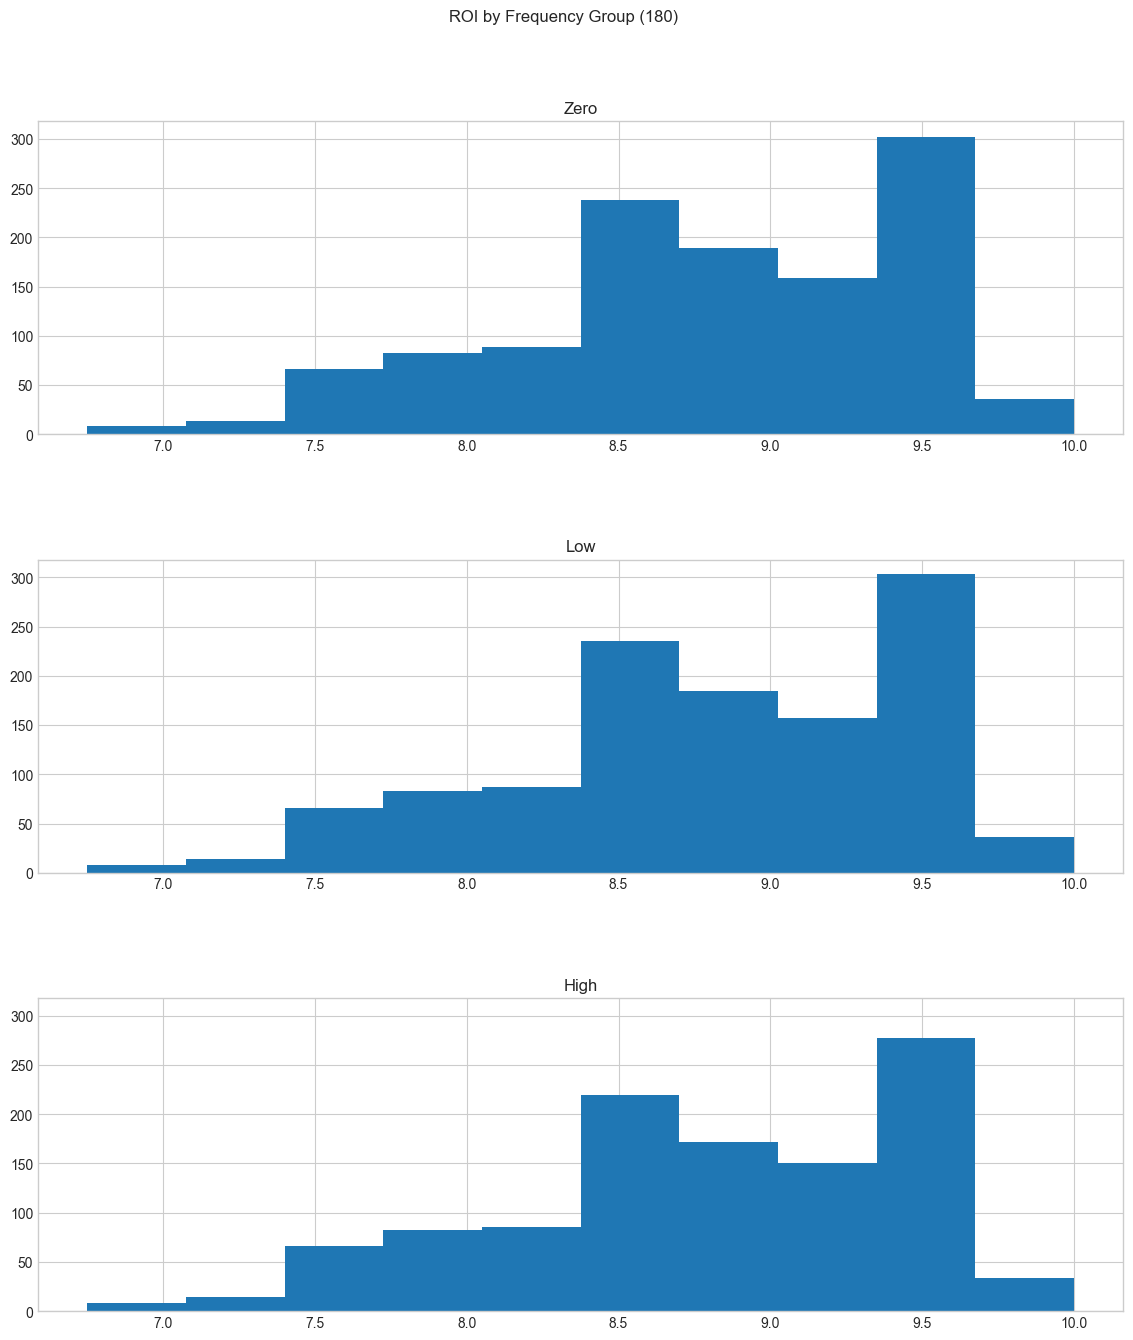

In [124]:
#bar roi by frequency

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

subTitles =['Zero','Low','High']

plot_df = [favROI_df_Z[favROI_df_Z['az']==180],favROI_df_O[favROI_df_O['az']==180],favROI_df_F[favROI_df_F['az']==180]]
for f in range(3):

    axs[f].hist(plot_df[f]['realRoi'])
    axs[f].set_title(subTitles[f])
    #axs[f].set_ylabel('DLRP W') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('ROI by Frequency Group (180)')
    
plt.show()

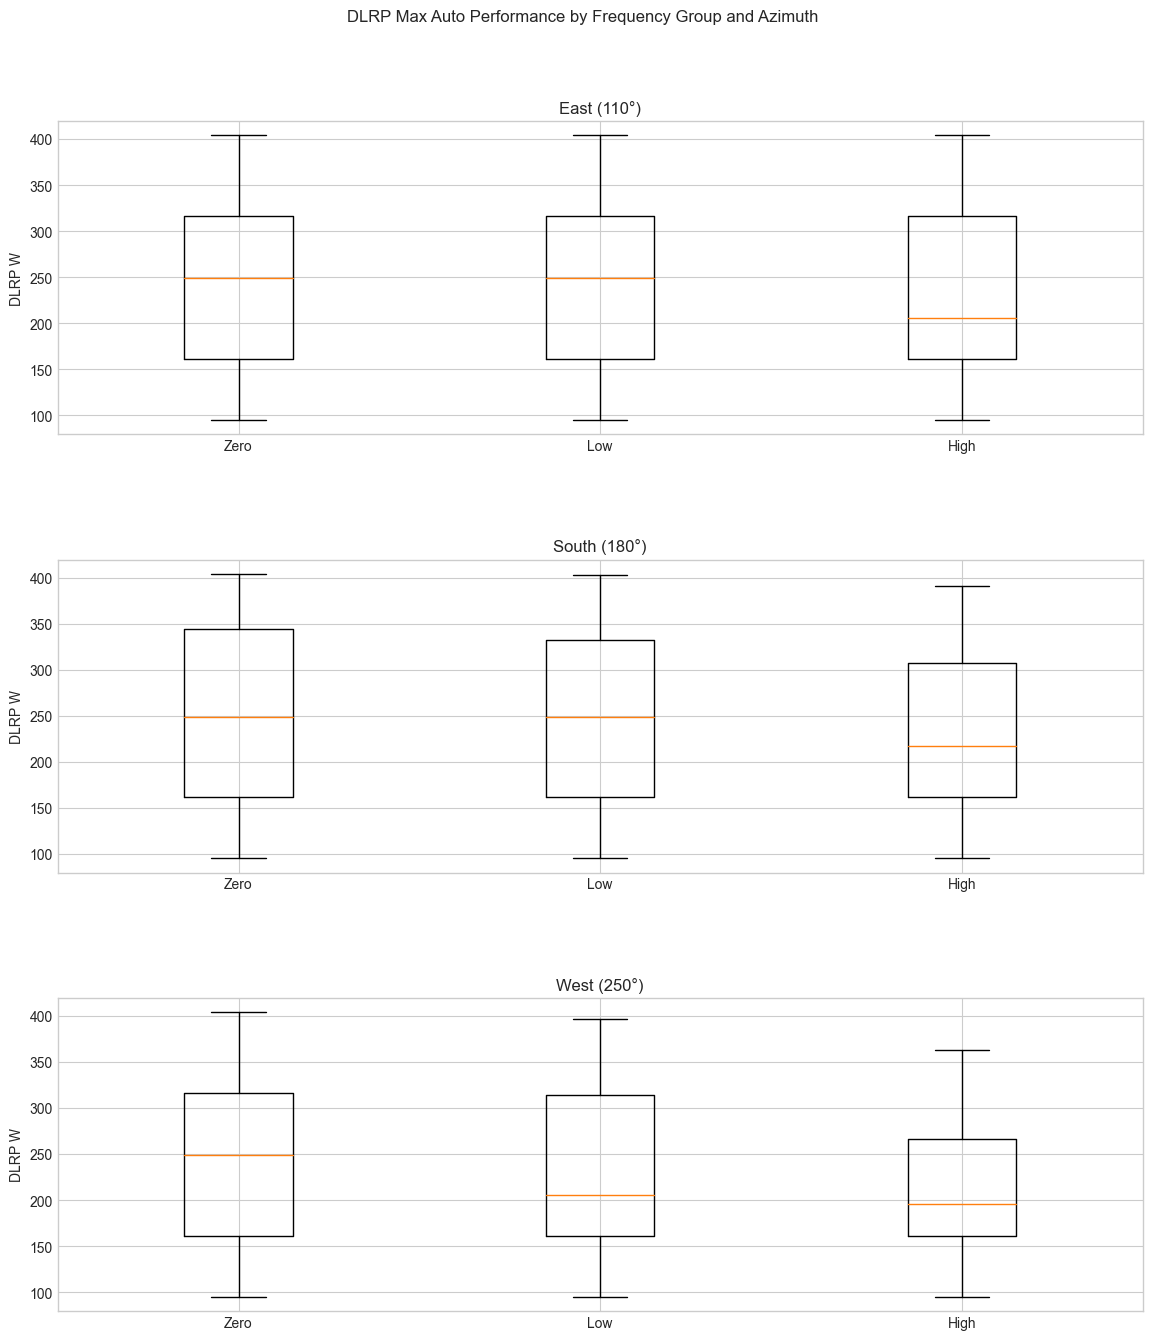

In [125]:
#box plot for IAR

fig, axs = plt.subplots(3,1, figsize=(14, 14), sharey=True)

azi = [110,180,250]
subTitles =['East','South','West']

#get labels using south facing facade because there are no non-data networks
# myLabels=[]
# for n in myNetworks:
#     mN = favROI_df_Z[favROI_df_Z['network'] == n]
#     myLabels.append(n + "\n(T"+ str(getStartTime(n)) + ", $" + str(getTotalRate(n)) +")")

for a in range(3):
    boxPlotData = []

    boxPlotData.append(list(favROI_df_Z[favROI_df_Z['az'] == azi[a]]['avgMAPw_D']))
    boxPlotData.append(list(favROI_df_O[favROI_df_O['az'] == azi[a]]['avgMAPw_D']))
    boxPlotData.append(list(favROI_df_F[favROI_df_F['az'] == azi[a]]['avgMAPw_D']))

#     for n in myNetworks:
#         bP = bPD[bPD['network'] == n]
#         boxPlotData.append(list(bP['incomeAfterRoi']))

    axs[a].boxplot(boxPlotData, labels=['Zero','Low','High'])
    axs[a].set_title(subTitles[a] + ' ('+str(azi[a])+'\N{DEGREE SIGN})')
    axs[a].set_ylabel('DLRP W') 

fig.subplots_adjust(bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)
fig.suptitle('DLRP Max Auto Performance by Frequency Group and Azimuth')
    
plt.show()

# What systems are unique to different frequency groups?

## Loads


### Typical Appliances

#### Fixed
* Refrigerator

#### Behavior Dependent
Note that baselines are determined by X, so random loads that aren't used at generally the same time each day wouldn't be considered.
* AC
* Fan
* Lamp
* Overhead lights
* Computer
* Electric Stove
* Convection stove

### 4 hour rates

In [126]:
favROI_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batModel', 'batWh', 'batWhAC',
       'effEff', 'dischargeRateW', 'capex', 'dollarPerBatkWh', 'dailyPVWAC_4M',
       'annualPVkWhDC_degraded', 'annualPVkWhAC_degraded', 'avoidedGridCosts',
       'immediateEventAmt', 'avgAutoParticipationMonthlyW_C',
       'avgAutoParticipationMonthlyW_D', 'avgAutoParticipationAnnualW_C',
       'avgAutoParticipationAnnualW_D', 'avgMAPw_C', 'avgMAPw_D',
       'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D', 'drIncAnnual_C',
       'drIncAnnual_D', 'drPerformanceIncome', 'annualBenefit', 'realRoi',
       'Cycles', 'lifespan', 'workingLife', 'profitableYears',
       'incomeAfterRoi', 'iarSplit'],
      dtype='object')

In [127]:
#Discharge rate is the amount of power required to offload per hour during an event
# print('Min discharge rate: ' + str(min(favROI_df['dischargeRateW'])))
# print('Mean discharge rate: ' + str(favROI_df['dischargeRateW'].mean()))
# print('Median discharge rate: ' + str(favROI_df['dischargeRateW'].median()))
# print('Max discharge rate: ' + str(max(favROI_df['dischargeRateW'])))

In [128]:
#Max stored available energy AC
favROI_df['availWhAC'] = favROI_df['batWhAC']*.8

print('Available Stored Energy:')
minStoredWh = min(favROI_df['availWhAC'])
maxStoredWh = max(favROI_df['availWhAC'])

print('Min: ' + str(minStoredWh))
print('Mean: ' + str(favROI_df['availWhAC'].mean()))
print('Median: ' + str(favROI_df['availWhAC'].median()))
print('Max: ' + str(maxStoredWh))

Available Stored Energy:
Min: 397.09751586842384
Mean: 966.7926175700919
Median: 1012.4728291503769
Max: 1635.087562992832


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [129]:
# Typical refrigerator
# source: https://www.energysage.com/electricity/house-watts/how-many-watts-does-a-refrigerator-use/#:~:text=A%20home%20refrigerator's%20power%20consumption,amps%20and%20about%20120%20volts.
fridgeDutyCycle = .333

fridgeMaxW = 800 * fridgeDutyCycle
fridgeMinW = 300 * fridgeDutyCycle

print('Fridge Watts')
print('Max: ' + str(fridgeMaxW) + 'W (' + str(fridgeMaxW * 24) + ' Wh/day)')
print('Min: ' + str(fridgeMinW) + 'W (' + str(fridgeMinW * 24) + ' Wh/day)')


Fridge Watts
Max: 266.40000000000003W (6393.6 Wh/day)
Min: 99.9W (2397.6000000000004 Wh/day)


In [130]:
# Min and Max Static Load Consumption Times
favROI_df['staticRTmin'] = favROI_df['availWhAC']/fridgeMaxW
favROI_df['staticRTmax'] = favROI_df['availWhAC']/fridgeMinW

print("min static consumption time: " + str(min(favROI_df['staticRTmin'])))
print("max static consumption time: " + str(max(favROI_df['staticRTmax'])))

print("Mean Min/Max")
print("mean min static consumption time: " + str(favROI_df['staticRTmin'].median()))
print("mean max static consumption time: " + str(favROI_df['staticRTmax'].median()))

min static consumption time: 1.4906062907973865
max static consumption time: 16.36724287280112
Mean Min/Max
mean min static consumption time: 3.8005736829969097
mean max static consumption time: 10.134863154658428


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
#dynamic load requirements

#DR inc
avgAnnDR_C_Min = []
avgAnnDR_C_Max = []

favROI_df['dynamicLoadMin'] = favROI_df['avgMAPw_C']-fridgeMaxW
favROI_df['dynamicLoadMax'] = favROI_df['avgMAPw_C']-fridgeMinW

print('Dynamic Load Requirements During CRSP Events')
print('Min: ' + str(max(0,min(favROI_df['dynamicLoadMin']))))
print('Max: ' + str(max(favROI_df['dynamicLoadMin'])))
print('Median Range: ' + str(favROI_df['avgMAPw_C'].median()-fridgeMaxW) + ' - ' + str(favROI_df['avgMAPw_C'].median()-fridgeMinW))

Dynamic Load Requirements During CRSP Events
Min: 0
Max: 353.27249090043875
Median Range: 29.18855023127435 - 195.68855023127438


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Final Analysis

Compare to Nest thermostat

## Get Favorable Battery Makes and Models

In [132]:
hardware_df = pd.read_csv('data/PowerStations_LiFePo4_Feb1.csv')

#clean data - these columns aren't used in this analysis
hardware_df = hardware_df.drop(columns=['Link','Battery Type','App Control','Bypass Mode','Min PV Voltage','Max PV Voltage','Max AC Input Amps'
                                        , 'Warranty Years','Lifespan','Notes','Real Minimum Grid Charge Efficiency','Estimated Minimum Grid Charge Efficiency'])


In [133]:
favBatWh

[680.96,
 614.0,
 1536.0,
 1920.0,
 1152.0,
 1440.0,
 2000.0,
 992.0,
 1488.0,
 2232.0,
 2048.0,
 2073.0,
 1330.0,
 960.0]

In [134]:
#filter by favorable battery type
favBat_df = hardware_df[hardware_df['Battery Wh'].isin(favBatWh)]

#filter by battery size
favBat_df = favBat_df[favBat_df['Battery Wh'] <= 2000]

#filter by dod
favBat_df = favBat_df[favBat_df['DoD'] >= 80]

display(favBat_df.shape)

favBat_df

(13, 20)

,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,AC Charger Watts,Inverter Efficiency,Retail Price (11/12/2023),Full Price (11/20/2023),Retail Price (12/30/2023),Retail Price (1/11/2024),Retail Price (1/26/2024),Unregulated Output,Cycles,DoD
4,Pecron,E600LFP,614.0,400,0.651466,7.0,1200,NaN,2.2,NaN,NaN,85.0,299.0,499.0,299.0,NaN,329.0,False,3500,80
5,Pecron,E1500LFP Expandable,1536.0,800,0.520833,7.0,2200,1400.0,1.8,NaN,NaN,85.0,899.0,1299.0,899.0,NaN,799.0,False,3500,80
6,Pecron,E2000LFP Expandable,1920.0,1200,0.625000,7.0,2000,NaN,2.0,NaN,NaN,85.0,899.0,1499.0,899.0,NaN,899.0,False,3500,80
17,Bluetti,AC180,1152.0,500,0.434028,10.0,1800,1440.0,NaN,0.750000,NaN,90.0,669.0,999.0,799.0,NaN,649.0,False,3500,80
18,Bluetti,AC180P,1440.0,500,0.347222,10.0,1800,1440.0,NaN,0.750000,NaN,90.0,1099.0,1299.0,999.0,NaN,999.0,False,3500,80
19,Bluetti,AC200P,2000.0,700,0.350000,12.0,2000,500.0,4.5,NaN,NaN,90.0,1199.0,1199.0,1199.0,NaN,1199.0,False,3500,80
33,Anker,SOLIX F1500,1536.0,600,0.390625,NaN,1800,NaN,2.0,NaN,1000.0,85.0,NaN,NaN,NaN,799.0,1399.0,False,3000,80
36,Oupes,1200 Portable Power Station,992.0,240,0.241935,NaN,1200,NaN,6.5,NaN,200.0,93.0,499.0,549.0,499.0,NaN,549.0,False,3500,80
37,Oupes,1800 Portable Power Station,1488.0,480,0.322581,NaN,1800,NaN,8.0,NaN,200.0,93.0,719.0,799.0,699.0,NaN,699.0,False,3500,80
48,Dabbsson,DBS1300,1330.0,400,0.300752,NaN,1200,NaN,NaN,0.733333,NaN,80.0,699.0,899.0,599.0,NaN,599.0,False,4500,80


# Validation Comparison

Comparison to HOMER outputs

In [135]:
#get lists of batteries by network
favROI_df_Z['batModel']

186       Explorer 700 Plus
189       Explorer 700 Plus
192       Explorer 700 Plus
195       Explorer 700 Plus
198       Explorer 700 Plus
                ...        
157818                P2001
157821                P2001
157824                P2001
157827                P2001
157830                P2001
Name: batModel, Length: 2538, dtype: object

In [136]:
results_df.keys()

Index(['network', 'eventStart', 'az', 'pvW', 'batModel', 'batWh', 'batWhAC',
       'effEff', 'dischargeRateW', 'capex', 'dollarPerBatkWh', 'dailyPVWAC_4M',
       'annualPVkWhDC_degraded', 'annualPVkWhAC_degraded', 'avoidedGridCosts',
       'immediateEventAmt', 'avgAutoParticipationMonthlyW_C',
       'avgAutoParticipationMonthlyW_D', 'avgAutoParticipationAnnualW_C',
       'avgAutoParticipationAnnualW_D', 'avgMAPw_C', 'avgMAPw_D',
       'totalDRratekW', 'drIncMonthly_C', 'drIncMonthly_D', 'drIncAnnual_C',
       'drIncAnnual_D', 'drPerformanceIncome', 'annualBenefit', 'realRoi',
       'Cycles', 'lifespan', 'workingLife', 'profitableYears',
       'incomeAfterRoi', 'iarSplit'],
      dtype='object')